# Data Mining Project - A cluster analysis of XYZ Sports Company
Group 69
- Diogo Pires, 20230534
- Manuel Gonçalves, 20230466
- Vitor Souto Neves, 20230548

In [1]:
# Data Manipulation and Analysis
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
plt.set_loglevel('critical')
import seaborn as sns

# Date and Time Handling
from datetime import datetime, timedelta

# Imputation
from sklearn.impute import KNNImputer

# Dimensionality Reduction
from sklearn.decomposition import PCA

# Data Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

# Data Profiling
from ydata_profiling import ProfileReport
import missingno as msno

# Clustering Algorithms
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.vq import kmeans, vq, whiten

from math import ceil, floor, pi

# Self-organizing maps
import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView

# import umap.umap_ as umap
from cuml import UMAP

import warnings; warnings.filterwarnings('ignore')

CUDA Driver version 12.2
CUDA Runtime version 11.8
call runtime api: cudaRuntimeGetVersion
init
call driver api: cuInit
call driver api: cuCtxGetCurrent
call driver api: cuDeviceGetCount
call driver api: cuDeviceGet
call driver api: cuDeviceGetAttribute
call driver api: cuDeviceGetAttribute
call driver api: cuDeviceGetName
call driver api: cuDeviceGetUuid_v2
call driver api: cuDevicePrimaryCtxRetain
call driver api: cuCtxPushCurrent_v2
call driver api: cuMemGetInfo_v2


# 1. Data import

In [2]:
original = pd.read_csv('../data/raw/XYZ_sports_dataset.csv',sep=';')
df = original.copy()
df.head()

ID  Age  Gender  Income EnrollmentStart EnrollmentFinish  \
0  10000   60  Female  5500.0      2019-09-03       2019-10-31   
1  10001   29  Female  2630.0      2014-08-12       2015-09-14   
2  10002   23    Male  1980.0      2017-05-02       2017-06-01   
3  10003    9    Male     0.0      2018-09-05       2019-02-12   
4  10004   35    Male  4320.0      2016-04-20       2018-06-07   

  LastPeriodStart LastPeriodFinish DateLastVisit  DaysWithoutFrequency  ...  \
0      2019-07-01       2019-12-31    2019-10-30                     1  ...   
1      2015-01-01       2015-12-31    2015-07-16                    60  ...   
2      2017-01-01       2017-06-30    2017-05-25                     7  ...   
3      2018-07-01       2019-06-30    2019-01-21                    22  ...   
4      2018-01-01       2018-06-30    2017-11-09                   210  ...   

   OtherActivities  NumberOfFrequencies  AttendedClasses  \
0              0.0                  9.0                7   
1              0.0                 23.0                1   
2              0.0                  6.0                0   
3              0.0                 20.0                2   
4              NaN                 41.0                0   

   AllowedWeeklyVisitsBySLA  AllowedNumberOfVisitsBySLA  RealNumberOfVisits  \
0                       NaN                        6.28                   2   
1                       2.0                       17.42                   1   
2                       7.0                       30.03                   6   
3                       2.0                       17.72                   3   
4                       7.0                       60.97                   0   

   NumberOfRenewals  HasReferences  NumberOfReferences  Dropout  
0                 0            0.0                   0        0  
1                 2            0.0                   0        1  
2                 0            0.0                   0        1  
3                 0            0.0                   0        1  
4                 3            0.0                   0        1  

[5 rows x 31 columns]

In [3]:
print(df.shape)

(14942, 31)


## Metadata


- **ID** - The unique identifier of the record
- **Age** - Age of the user at October 31st, 2019 if it is not a dropout, or age of the user at the date specified in attribute EnrollmentFinish if it is a dropout
- **Gender** - Gender of the user (Male or Female)
- **Income** - Monthly salary of user
- **EnrollmentStart** - Date of first enrollment
- **EnrollmentFinish** - Finish date of last enrollment
- **LastPeriodStart** - Start date of the last activity or the last two months if less
- **LastPeriodFinish** - End date of last activity or last two months if less
- **DateLastVisit** - Date and time of the user’s last visit to the sport facility
- **DaysWithoutFrequency** - Number of days the user did not visit the facility before being considered a dropout
- **LifetimeValue** - Total amount paid by the customer during the period in which he was enrolled (between EnrollmentStart and EnrollmentFinish)
- **UseByTime** - Indicates whether the user was enrolled in this form of use (True if he was, False otherwise)
- **AthleticsActivities** - Indicates if the user was ever enrolled in athletics activities during the period between EnrollmentStart and EnrollmentFinish (True if it was, False otherwise)
- **WaterActivities** - Indicates if the user was ever enrolled in water activities during the period between EnrollmentStart and EnrollmentFinish (True if it was, False otherwise)
- **FitnessActivities** - Indicates if the user was ever enrolled in fitness activities during the period between EnrollmentStart and EnrollmentFinish (True if it was, False otherwise)
- **DanceActivities** - Indicates if the user was ever enrolled in dance activities during the period between EnrollmentStart and EnrollmentFinish (True if it was, False otherwise)
- **TeamActivities** - Indicates if the user was ever enrolled in team activities during the period between EnrollmentStart and EnrollmentFinish (True if it was, False otherwise)
- **RacketActivities** - Indicates if the user was ever enrolled in racket activities during the period between EnrollmentStart and EnrollmentFinish (True if it was, False otherwise)
- **CombatActivities** - Indicates if the user was ever enrolled in combat sports activities during the period between EnrollmentStart and EnrollmentFinish (True if it was, False otherwise)
- **NatureActivities** - Indicates if the user was ever enrolled in nature activities during the period between EnrollmentStart and EnrollmentFinish (True if it was, False otherwise)
- **SpecialActivities** - Indicates if the user was enrolled in sports for disabled people during the period between EnrollmentStart and EnrollmentFinish (True if it was, False otherwise)
- **OtherActivities** - Indicates if the user was ever enrolled in other activities that do not fall into the other categories during the period between EnrollmentStart and EnrollmentFinish (True if it was, False otherwise)
- **NumberOfFrequencies** - Number of visits to the sports facility since the date indicated in EnrollmentStart and the date indicated in EnrollmentFinish
- **AttendedClasses** - Number of classes the user attended between EnrollmentStart and EnrollmentFinish
- **AllowedWeeklyVisitsBySLA** - Indicates the number of weekly visits that the user can make to the facilities according to the service he had hired in the last 2 months of his registration (between LastPeriodStart and LastPeriodFinish)
- **AllowedNumberOfVisitsBySLA** - Indicates the total number of visits that the user can make to the facilities according to the service he had hired in the last 2 months of his registration (between LastPeriodStart and LastPeriodFinish)
- **RealNumberOfVisits** - The actual number of visits that the user made to the facilities in the last period of his registration (between LastPeriodStart and LastPeriodFinish)
- **NumberOfRenewals** - Number of renewals during the registration period (between EnrollmentStart and EnrollmentFinish)
- **HasReferences** - This field contains the value True if NumberOfReferences > 0, or False otherwise
- **NumberOfReferences** - Number of people with whom the user is related by family relationship or friendship
- **Dropout** - Represents the user’s enrollment status, assuming the value True if he is quitting or False if he is not
s quitting, False if he is not |

# 2. Data Exploration and Preprocessing

In [4]:
df.describe(include="all").T

count unique         top  freq         mean  \
ID                          14942.0    NaN         NaN   NaN      17470.5   
Age                         14942.0    NaN         NaN   NaN    26.015794   
Gender                        14942      2      Female  8931          NaN   
Income                      14447.0    NaN         NaN   NaN  2230.816086   
EnrollmentStart               14942   1490  2015-03-02    92          NaN   
EnrollmentFinish              14942   1300  2015-09-16  1684          NaN   
LastPeriodStart               14942     12  2019-07-01  3172          NaN   
LastPeriodFinish              14942     11  2019-12-31  3694          NaN   
DateLastVisit                 14942   1384  2019-10-31   475          NaN   
DaysWithoutFrequency        14942.0    NaN         NaN   NaN    81.224936   
LifetimeValue               14942.0    NaN         NaN   NaN   302.561871   
UseByTime                   14942.0    NaN         NaN   NaN     0.047116   
AthleticsActivities         14906.0    NaN         NaN   NaN      0.00738   
WaterActivities             14905.0    NaN         NaN   NaN     0.296209   
FitnessActivities           14907.0    NaN         NaN   NaN     0.576038   
DanceActivities             14906.0    NaN         NaN   NaN          0.0   
TeamActivities              14907.0    NaN         NaN   NaN     0.055544   
RacketActivities            14905.0    NaN         NaN   NaN     0.023415   
CombatActivities            14909.0    NaN         NaN   NaN     0.107921   
NatureActivities            14895.0    NaN         NaN   NaN          0.0   
SpecialActivities           14898.0    NaN         NaN   NaN     0.026514   
OtherActivities             14907.0    NaN         NaN   NaN     0.001878   
NumberOfFrequencies         14916.0    NaN         NaN   NaN    40.120542   
AttendedClasses             14942.0    NaN         NaN   NaN    10.152456   
AllowedWeeklyVisitsBySLA    14407.0    NaN         NaN   NaN     5.759561   
AllowedNumberOfVisitsBySLA  14942.0    NaN         NaN   NaN    41.636299   
RealNumberOfVisits          14942.0    NaN         NaN   NaN     5.320707   
NumberOfRenewals            14942.0    NaN         NaN   NaN      1.20526   
HasReferences               14930.0    NaN         NaN   NaN     0.019893   
NumberOfReferences          14942.0    NaN         NaN   NaN     0.022286   
Dropout                     14942.0    NaN         NaN   NaN     0.800964   

                                    std      min       25%      50%       75%  \
ID                          4313.528196  10000.0  13735.25  17470.5  21205.75   
Age                           14.156582      0.0      19.0     23.0      31.0   
Gender                              NaN      NaN       NaN      NaN       NaN   
Income                      1566.527734      0.0    1470.0   1990.0    2790.0   
EnrollmentStart                     NaN      NaN       NaN      NaN       NaN   
EnrollmentFinish                    NaN      NaN       NaN      NaN       NaN   
LastPeriodStart                     NaN      NaN       NaN      NaN       NaN   
LastPeriodFinish                    NaN      NaN       NaN      NaN       NaN   
DateLastVisit                       NaN      NaN       NaN      NaN       NaN   
DaysWithoutFrequency         144.199576      0.0      13.0     41.0     83.75   
LifetimeValue                364.319566      0.0      83.6    166.2   355.075   
UseByTime                      0.211893      0.0       0.0      0.0       0.0   
AthleticsActivities             0.08559      0.0       0.0      0.0       0.0   
WaterActivities                  0.4566      0.0       0.0      0.0       1.0   
FitnessActivities              0.494201      0.0       0.0      1.0       1.0   
DanceActivities                     0.0      0.0       0.0      0.0       0.0   
TeamActivities                 0.229047      0.0       0.0      0.0       0.0   
RacketActivities               0.151222      0.0       0.0      0.0       0.0   
CombatActivities          

In [5]:
df.shape

(14942, 31)

## 2.1 Duplicates

In [6]:
df.drop_duplicates()
df.shape

(14942, 31)

## 2.2 Data types

In [7]:
df.dtypes

ID                              int64
Age                             int64
Gender                         object
Income                        float64
EnrollmentStart                object
EnrollmentFinish               object
LastPeriodStart                object
LastPeriodFinish               object
DateLastVisit                  object
DaysWithoutFrequency            int64
LifetimeValue                 float64
UseByTime                       int64
AthleticsActivities           float64
WaterActivities               float64
FitnessActivities             float64
DanceActivities               float64
TeamActivities                float64
RacketActivities              float64
CombatActivities              float64
NatureActivities              float64
SpecialActivities             float64
OtherActivities               float64
NumberOfFrequencies           float64
AttendedClasses                 int64
AllowedWeeklyVisitsBySLA      float64
AllowedNumberOfVisitsBySLA    float64
RealNumberOf

In [8]:
# List of columns to convert to datetime
date_columns = ['EnrollmentStart', 'EnrollmentFinish', 'LastPeriodStart', 'LastPeriodFinish', 'DateLastVisit']

# Convert the specified columns to datetime objects
df[date_columns] = df[date_columns].apply(pd.to_datetime, errors='coerce')

In [9]:
df.dtypes

ID                                     int64
Age                                    int64
Gender                                object
Income                               float64
EnrollmentStart               datetime64[ns]
EnrollmentFinish              datetime64[ns]
LastPeriodStart               datetime64[ns]
LastPeriodFinish              datetime64[ns]
DateLastVisit                 datetime64[ns]
DaysWithoutFrequency                   int64
LifetimeValue                        float64
UseByTime                              int64
AthleticsActivities                  float64
WaterActivities                      float64
FitnessActivities                    float64
DanceActivities                      float64
TeamActivities                       float64
RacketActivities                     float64
CombatActivities                     float64
NatureActivities                     float64
SpecialActivities                    float64
OtherActivities                      float64
NumberOfFr

## 2.3 Metric and non-metric features

In [10]:
# Metric Features
metric_features = [
    'Age',
    'Income',
    'EnrollmentStart',
    'EnrollmentFinish',
    'LastPeriodStart',
    'LastPeriodFinish',
    'DateLastVisit',
    'DaysWithoutFrequency',
    'LifetimeValue',
    'NumberOfFrequencies',
    'AttendedClasses',
    'AllowedWeeklyVisitsBySLA',
    'AllowedNumberOfVisitsBySLA',
    'RealNumberOfVisits',
    'NumberOfRenewals',
    'NumberOfReferences'
]

# Non-Metric Features
non_metric_features = [
    'Gender',
    'UseByTime',
    'AthleticsActivities',
    'WaterActivities',
    'FitnessActivities',
    'DanceActivities',
    'TeamActivities',
    'RacketActivities',
    'CombatActivities',
    'NatureActivities',
    'SpecialActivities',
    'OtherActivities',
    'HasReferences',
    'Dropout'
]

## 2.4 Missing Values

In [11]:
df.isna().sum()*100 / len(df)

ID                            0.000000
Age                           0.000000
Gender                        0.000000
Income                        3.312810
EnrollmentStart               0.000000
EnrollmentFinish              0.000000
LastPeriodStart               0.000000
LastPeriodFinish              0.000000
DateLastVisit                 0.000000
DaysWithoutFrequency          0.000000
LifetimeValue                 0.000000
UseByTime                     0.000000
AthleticsActivities           0.240932
WaterActivities               0.247624
FitnessActivities             0.234239
DanceActivities               0.240932
TeamActivities                0.234239
RacketActivities              0.247624
CombatActivities              0.220854
NatureActivities              0.314550
SpecialActivities             0.294472
OtherActivities               0.234239
NumberOfFrequencies           0.174006
AttendedClasses               0.000000
AllowedWeeklyVisitsBySLA      3.580511
AllowedNumberOfVisitsBySL

In [12]:
df.isna().sum().sum()

1443

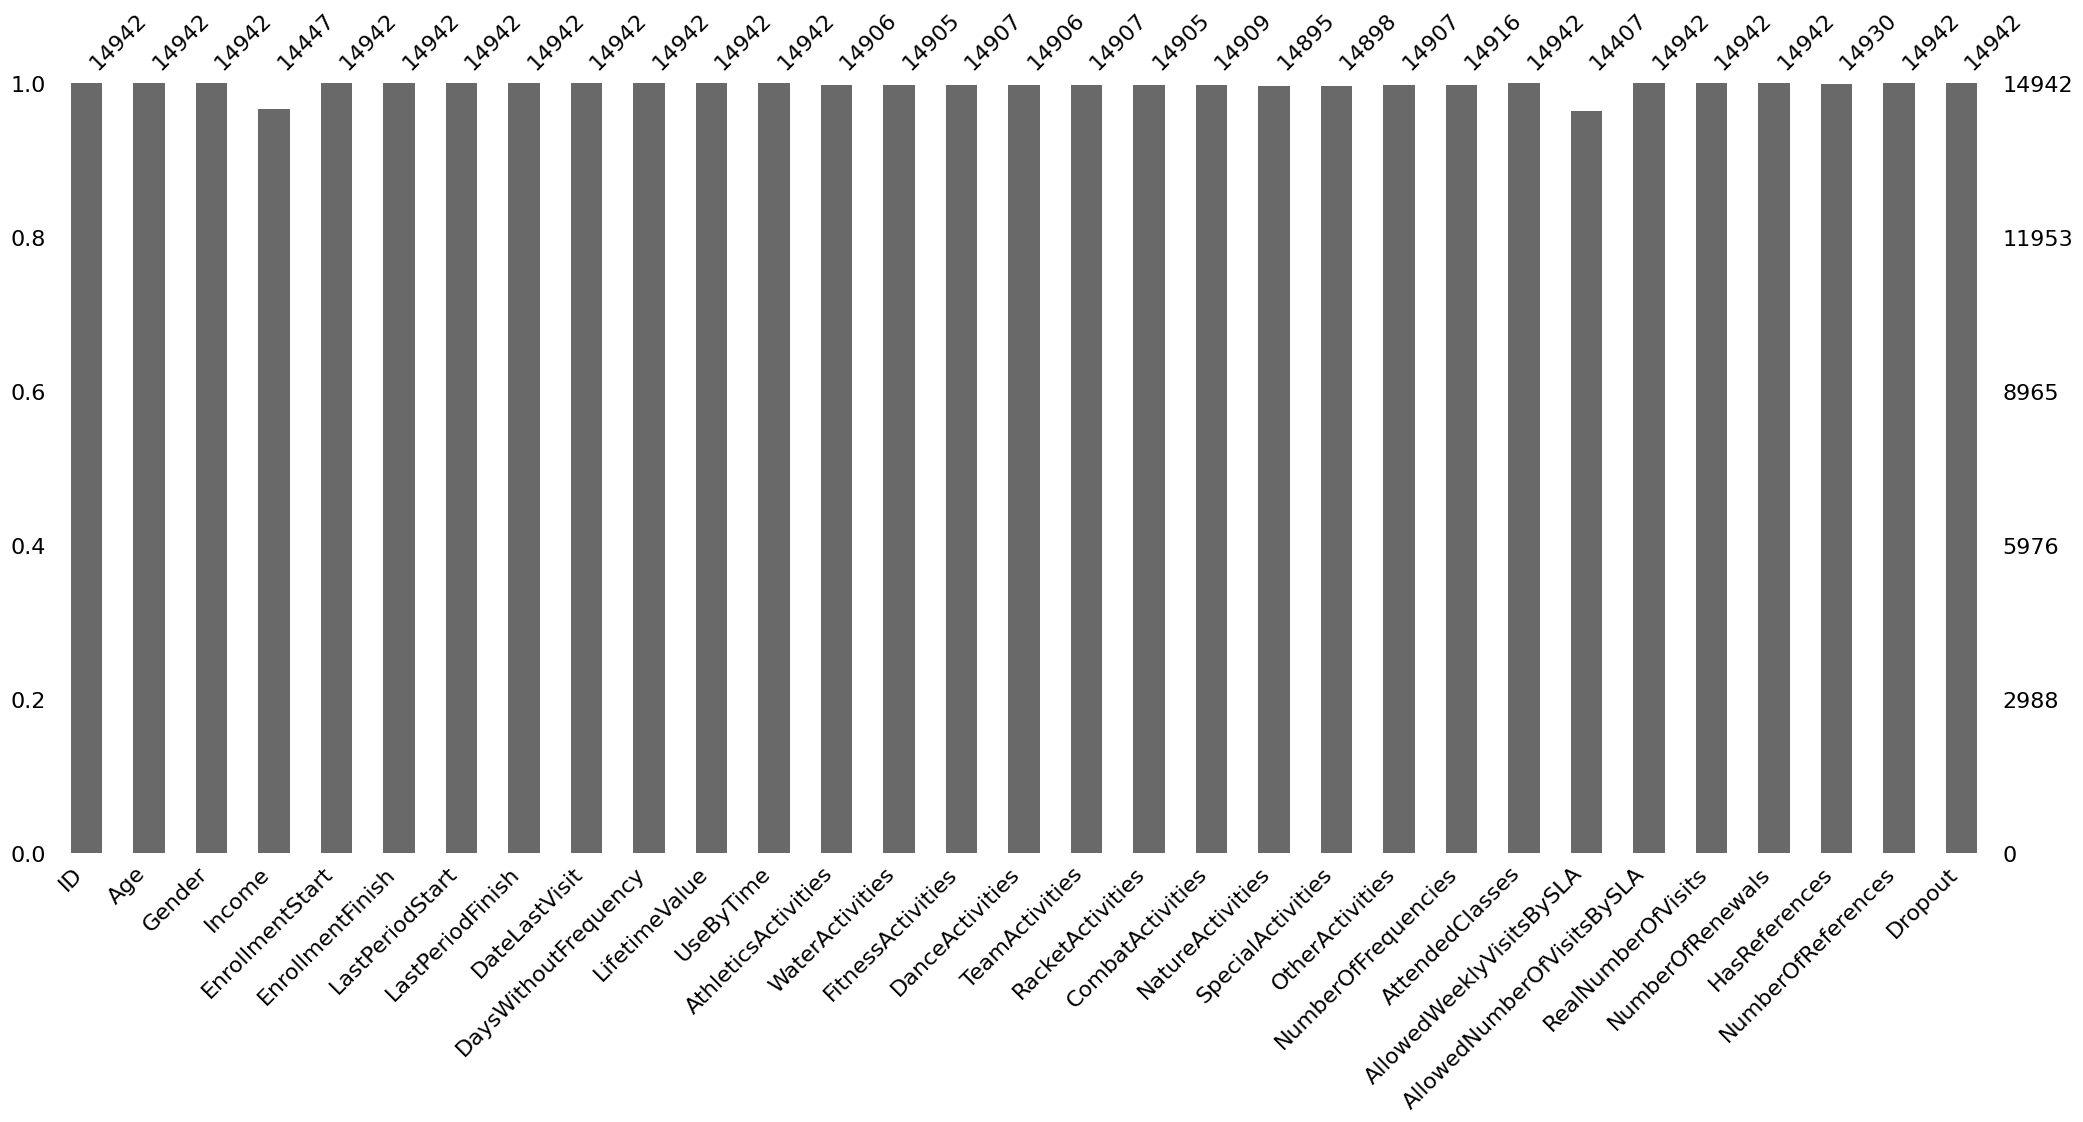

In [13]:
msno.bar(df);

In [14]:
print('Percentage of data kept after removing missing data:', np.round(df.dropna().shape[0] / original.shape[0], 4))

Percentage of data kept after removing missing data: 0.9074


In [15]:
print('Percentage of missing data coming from metric features', np.round(df[metric_features].isna().sum().sum()/df.isna().sum().sum(),2))
print('Percentage of missing data coming from non-metric features', np.round(df[non_metric_features].isna().sum().sum()/df.isna().sum().sum(),2))

Percentage of missing data coming from metric features 0.73
Percentage of missing data coming from non-metric features 0.27


- **Fill missing values**

In [16]:
# Create central dataframe for potential data imputation
df_central = df.copy()

In [17]:
df_central[metric_features].median()

Age                             23.00
Income                        1990.00
DaysWithoutFrequency            41.00
LifetimeValue                  166.20
NumberOfFrequencies             18.00
AttendedClasses                  0.00
AllowedWeeklyVisitsBySLA         7.00
AllowedNumberOfVisitsBySLA      38.99
RealNumberOfVisits               4.00
NumberOfRenewals                 1.00
NumberOfReferences               0.00
dtype: float64

In [18]:
modes = df_central[non_metric_features].mode().loc[0]
modes

Gender                 Female
UseByTime                   0
AthleticsActivities       0.0
WaterActivities           0.0
FitnessActivities         1.0
DanceActivities           0.0
TeamActivities            0.0
RacketActivities          0.0
CombatActivities          0.0
NatureActivities          0.0
SpecialActivities         0.0
OtherActivities           0.0
HasReferences             0.0
Dropout                     1
Name: 0, dtype: object

In [19]:
# Checking the HasReferences correlation with NumberOfReferences
df_central.groupby('HasReferences')['NumberOfReferences'].value_counts()

HasReferences  NumberOfReferences
0.0            0                     14633
1.0            1                       257
               2                        19
               0                        13
               3                         8
Name: NumberOfReferences, dtype: int64

In [20]:
references_df = df[['NumberOfReferences','HasReferences']]
references_df[references_df['HasReferences'].isna()]

NumberOfReferences  HasReferences
1260                    1            NaN
1427                    1            NaN
3032                    1            NaN
4532                    1            NaN
4582                    1            NaN
8306                    1            NaN
8667                    1            NaN
10374                   1            NaN
10409                   2            NaN
10985                   1            NaN
12457                   1            NaN
14827                   2            NaN

In [21]:
# As if NumberOfReferences != 0 HasReferences == 1, and all NaNs in HasReferences have NumberOfReferences != 0, we can impute the NaNs with 1
df_central['HasReferences'].fillna(value=1.0, inplace=True)

In [22]:
df_central.fillna(df_central[metric_features].median(), inplace=True)
df_central.fillna(modes, inplace=True)
df_central.isna().sum()  # checking how many NaNs we still have

ID                            0
Age                           0
Gender                        0
Income                        0
EnrollmentStart               0
EnrollmentFinish              0
LastPeriodStart               0
LastPeriodFinish              0
DateLastVisit                 0
DaysWithoutFrequency          0
LifetimeValue                 0
UseByTime                     0
AthleticsActivities           0
WaterActivities               0
FitnessActivities             0
DanceActivities               0
TeamActivities                0
RacketActivities              0
CombatActivities              0
NatureActivities              0
SpecialActivities             0
OtherActivities               0
NumberOfFrequencies           0
AttendedClasses               0
AllowedWeeklyVisitsBySLA      0
AllowedNumberOfVisitsBySLA    0
RealNumberOfVisits            0
NumberOfRenewals              0
HasReferences                 0
NumberOfReferences            0
Dropout                       0
dtype: i

In [23]:
# Creating new df copy to explore neighbordhood imputation
df_neighbors = df.copy()

In [24]:
# Seeing rows with NaNs
nans_index = df_neighbors.isna().any(axis=1)
df_neighbors[nans_index]

ID  Age  Gender  Income EnrollmentStart EnrollmentFinish  \
0      10000   60  Female  5500.0      2019-09-03       2019-10-31   
4      10004   35    Male  4320.0      2016-04-20       2018-06-07   
19     10019   28    Male  2510.0      2019-10-01       2019-10-31   
34     10034   74  Female  5210.0      2019-10-01       2019-10-31   
68     10068   43  Female     NaN      2016-09-16       2019-10-31   
...      ...  ...     ...     ...             ...              ...   
14904  24904   21  Female  1820.0      2019-09-23       2019-10-31   
14910  24910   25    Male  1600.0      2014-09-03       2015-09-14   
14929  24929   32  Female  4050.0      2017-10-31       2018-03-10   
14930  24930    4    Male     NaN      2017-06-30       2017-11-07   
14938  24938   39    Male     NaN      2015-09-17       2016-06-04   

      LastPeriodStart LastPeriodFinish DateLastVisit  DaysWithoutFrequency  \
0          2019-07-01       2019-12-31    2019-10-30                     1   
4          2018-01-01       2018-06-30    2017-11-09                   210   
19         2019-07-01       2019-12-31    2019-10-21                    10   
34         2019-07-01       2019-12-31    2019-10-11                    20   
68         2019-07-01       2019-12-31    2019-10-30                     1   
...               ...              ...           ...                   ...   
14904      2019-07-01       2019-12-31    2019-10-28                     3   
14910      2015-01-01       2015-06-30    2014-12-15                   273   
14929      2018-01-01       2018-06-30    2018-01-29                    40   
14930      2017-07-01       2017-12-31    2017-09-30                    38   
14938      2016-01-01       2016-06-30    2016-04-27                    38   

       ...  OtherActivities  NumberOfFrequencies  AttendedClasses  \
0      ...              0.0                  9.0                7   
4      ...              NaN                 41.0                0   
19     ...              0.0                  2.0                0   
34     ...              0.0                  4.0                0   
68     ...              0.0                214.0                0   
...    ...              ...                  ...              ...   
14904  ...              0.0                  9.0                0   
14910  ...              0.0                 17.0               17   
14929  ...              NaN                  8.0                0   
14930  ...              0.0                  5.0                5   
14938  ...              0.0                 57.0                0   

       AllowedWeeklyVisitsBySLA  AllowedNumberOfVisitsBySLA  \
0                           NaN                        6.28   
4                           7.0                       60.97   
19                          NaN                       24.01   
34                          NaN                       30.03   
68                          7.0                       21.98   
...                         ...                         ...   
14904                       NaN                       21.98   
14910                       3.0                       25.29   
14929                       7.0                       59.01   
14930                       2.0                       17.42   
14938                       7.0                       60.97   

       RealNumberOfVisits  NumberOfRenewals  HasReferences  \
0                       2                 0            0.0   
4                       0                 3            0.0   
19                      2                 0            0.0   
34                      4                 0            0.0   
68                      9                 3            0.0   
...                   ...               ...            ...   
14904                   5                 0            0.0   
14910                   0                 1            0.0   
14929                   5                 0            0.0   
14930                   7 

In [25]:
# Subtract '1970-01-01' and get the number of days as an int
df_neighbors['EnrollmentStart'] = (df_neighbors['EnrollmentStart'] - pd.to_datetime('1970-01-01')).dt.days
df_neighbors['EnrollmentFinish'] = (df_neighbors['EnrollmentFinish'] - pd.to_datetime('1970-01-01')).dt.days
df_neighbors['LastPeriodStart'] = (df_neighbors['LastPeriodStart'] - pd.to_datetime('1970-01-01')).dt.days
df_neighbors['LastPeriodFinish'] = (df_neighbors['LastPeriodFinish'] - pd.to_datetime('1970-01-01')).dt.days
df_neighbors['DateLastVisit'] = (df_neighbors['DateLastVisit'] - pd.to_datetime('1970-01-01')).dt.days

# Apply KNNImputer
imputer = KNNImputer(n_neighbors=5, weights="uniform")
df_neighbors[metric_features] = imputer.fit_transform(df_neighbors[metric_features])

# Convert back to original datetime format
df_neighbors['EnrollmentStart'] = pd.to_datetime('1970-01-01') + pd.to_timedelta(df_neighbors['EnrollmentStart'], unit='D')
df_neighbors['EnrollmentFinish'] = pd.to_datetime('1970-01-01') + pd.to_timedelta(df_neighbors['EnrollmentFinish'], unit='D')
df_neighbors['LastPeriodStart'] = pd.to_datetime('1970-01-01') + pd.to_timedelta(df_neighbors['LastPeriodStart'], unit='D')
df_neighbors['LastPeriodFinish'] = pd.to_datetime('1970-01-01') + pd.to_timedelta(df_neighbors['LastPeriodFinish'], unit='D')
df_neighbors['DateLastVisit'] = pd.to_datetime('1970-01-01') + pd.to_timedelta(df_neighbors['DateLastVisit'], unit='D')

In [26]:
# Display the updated DataFrame
df_neighbors.loc[nans_index, metric_features]

Age  Income EnrollmentStart EnrollmentFinish LastPeriodStart  \
0      60.0  5500.0      2019-09-03       2019-10-31      2019-07-01   
4      35.0  4320.0      2016-04-20       2018-06-07      2018-01-01   
19     28.0  2510.0      2019-10-01       2019-10-31      2019-07-01   
34     74.0  5210.0      2019-10-01       2019-10-31      2019-07-01   
68     43.0  3154.0      2016-09-16       2019-10-31      2019-07-01   
...     ...     ...             ...              ...             ...   
14904  21.0  1820.0      2019-09-23       2019-10-31      2019-07-01   
14910  25.0  1600.0      2014-09-03       2015-09-14      2015-01-01   
14929  32.0  4050.0      2017-10-31       2018-03-10      2018-01-01   
14930   4.0  1248.0      2017-06-30       2017-11-07      2017-07-01   
14938  39.0  3150.0      2015-09-17       2016-06-04      2016-01-01   

      LastPeriodFinish DateLastVisit  DaysWithoutFrequency  LifetimeValue  \
0           2019-12-31    2019-10-30                   1.0          89.35   
4           2018-06-30    2017-11-09                 210.0         373.20   
19          2019-12-31    2019-10-21                  10.0          52.00   
34          2019-12-31    2019-10-11                  20.0          38.50   
68          2019-12-31    2019-10-30                   1.0         849.80   
...                ...           ...                   ...            ...   
14904       2019-12-31    2019-10-28                   3.0          54.80   
14910       2015-06-30    2014-12-15                 273.0         285.20   
14929       2018-06-30    2018-01-29                  40.0         134.60   
14930       2017-12-31    2017-09-30                  38.0          77.60   
14938       2016-06-30    2016-04-27                  38.0         343.85   

       NumberOfFrequencies  AttendedClasses  AllowedWeeklyVisitsBySLA  \
0                      9.0              7.0                       4.0   
4                     41.0              0.0                       7.0   
19                     2.0              0.0                       3.4   
34                     4.0              0.0                       2.4   
68                   214.0              0.0                       7.0   
...                    ...              ...                       ...   
14904                  9.0              0.0                       3.0   
14910                 17.0             17.0                       3.0   
14929                  8.0              0.0                       7.0   
14930                  5.0              5.0                       2.0   
14938                 57.0              0.0                       7.0   

       AllowedNumberOfVisitsBySLA  RealNumberOfVisits  NumberOfRenewals  \
0                            6.28                 2.0               0.0   
4                           60.97                 0.0               3.0   
19                          24.01                 2.0               0.0   
34                          30.03                 4.0               0.0   
68                          21.98                 9.0               3.0   
...                           ...                 ...               ...   
14904                       21.98                 5.0               0.0   
14910                       25.29                 0.0               1.0   
14929                       59.01                 5.0               0.0   
14930                       17.42                 7.0               1.0   
14938                       60.97                 3.0               0.0   

       NumberOfReferences  
0                     0.0  
4                     0.0  
19                    0.0  
34                    0.0  
68                    0.0  
...                   ...  
14904                 0.0  
14910                 0.0  
14929                 0.0  
14930                 0.0  
14938                 0.0  

[1384 rows x 16 columns]

In [27]:
# Fill Nan for non metric features with mode
df_neighbors.fillna(df_neighbors[non_metric_features].mode().loc[0],inplace=True)

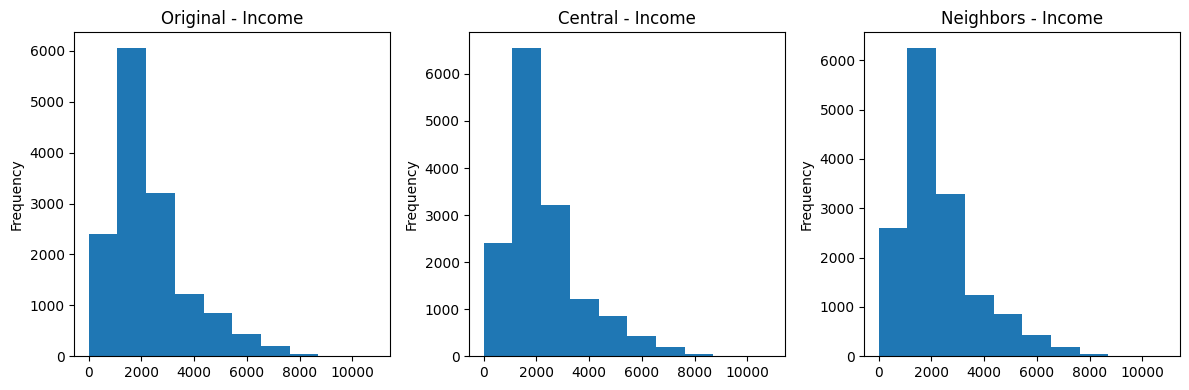

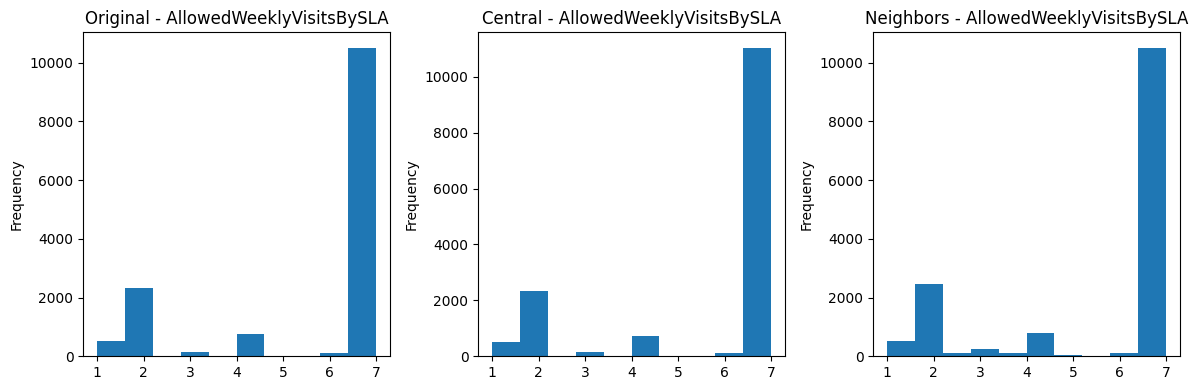

In [28]:
# Let's explore the imputation differences for the features with the most missing values
for feature in ['Income', 'AllowedWeeklyVisitsBySLA']:
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    original[feature].plot.hist(title='Original - ' + feature)

    plt.subplot(1, 3, 2)
    df_central[feature].plot.hist(title='Central - ' + feature)

    plt.subplot(1, 3, 3)
    df_neighbors[feature].plot.hist(title='Neighbors - ' + feature)

    plt.tight_layout()
    plt.show();

In [29]:
# let's keep the central imputation
df = df_central.copy()

## 2.5 Outliers

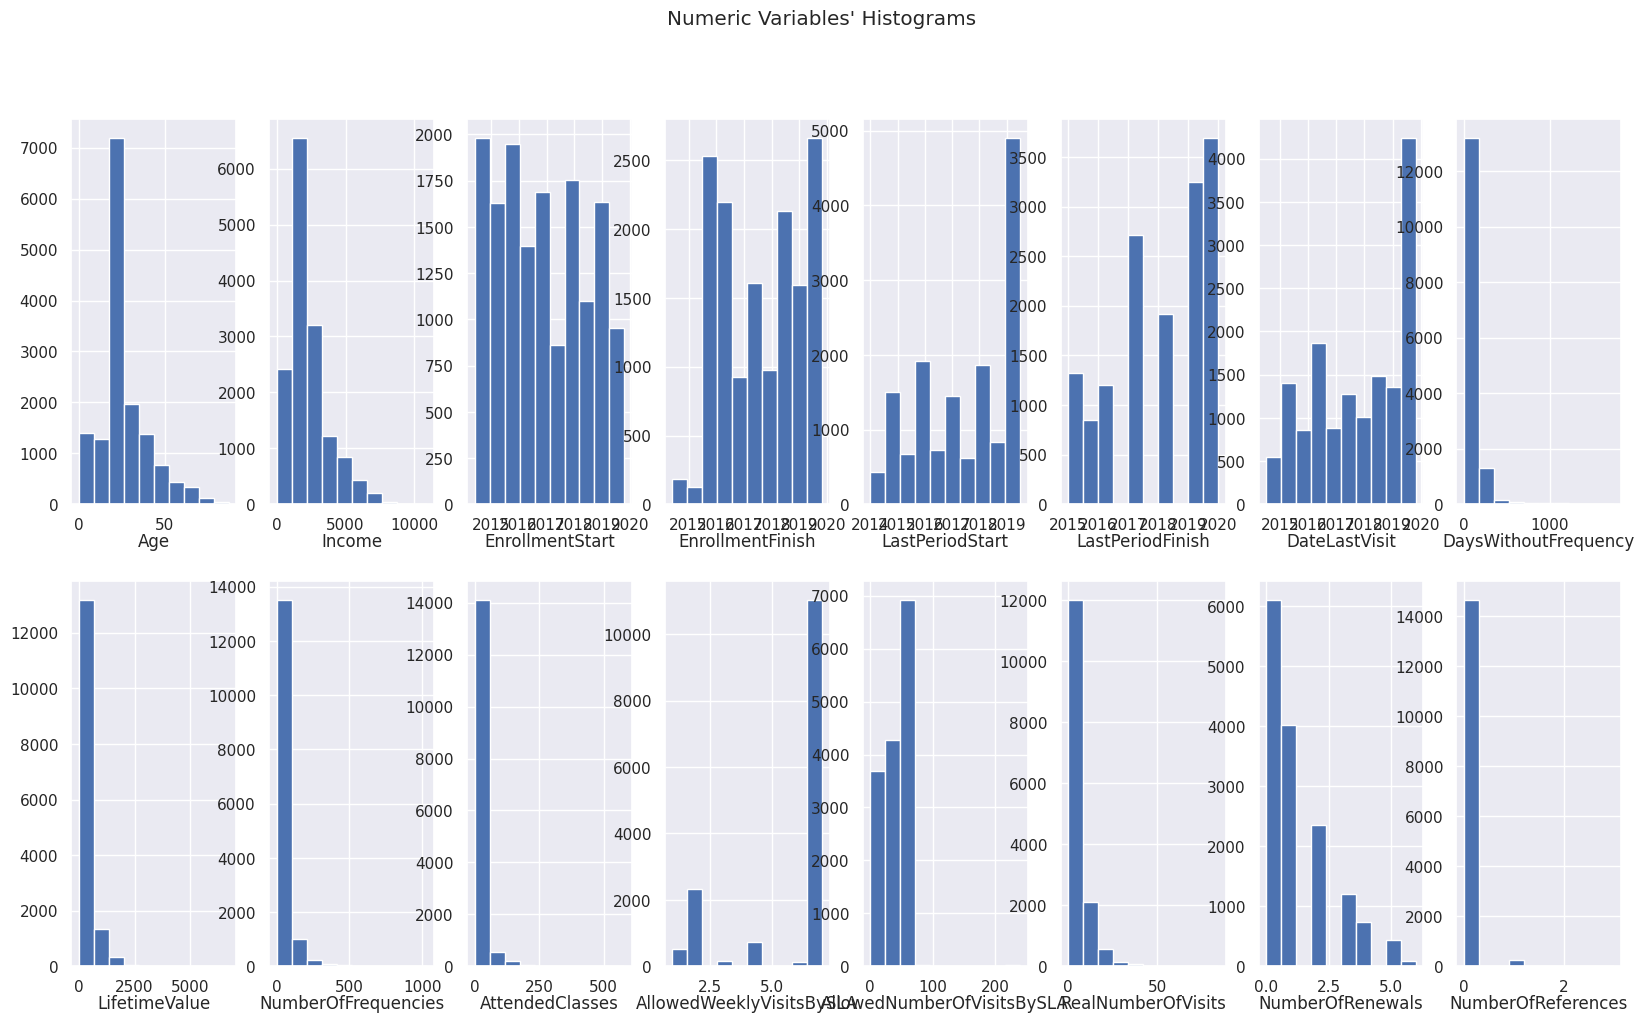

In [31]:
# Check histograms for numeric variables
sns.set()

fig, axes = plt.subplots(2, floor(len(metric_features) / 2), figsize=(20, 11))
for ax, feat in zip(axes.flatten(), metric_features):
    ax.hist(df[feat])
    ax.set_title(feat, y=-0.13)

title = "Numeric Variables' Histograms"

plt.suptitle(title)

plt.show();

In [32]:
# Removing datetimes to keep only numerical features
metric_features.remove('EnrollmentStart')
metric_features.remove('EnrollmentFinish')
metric_features.remove('LastPeriodStart')
metric_features.remove('LastPeriodFinish')
metric_features.remove('DateLastVisit')

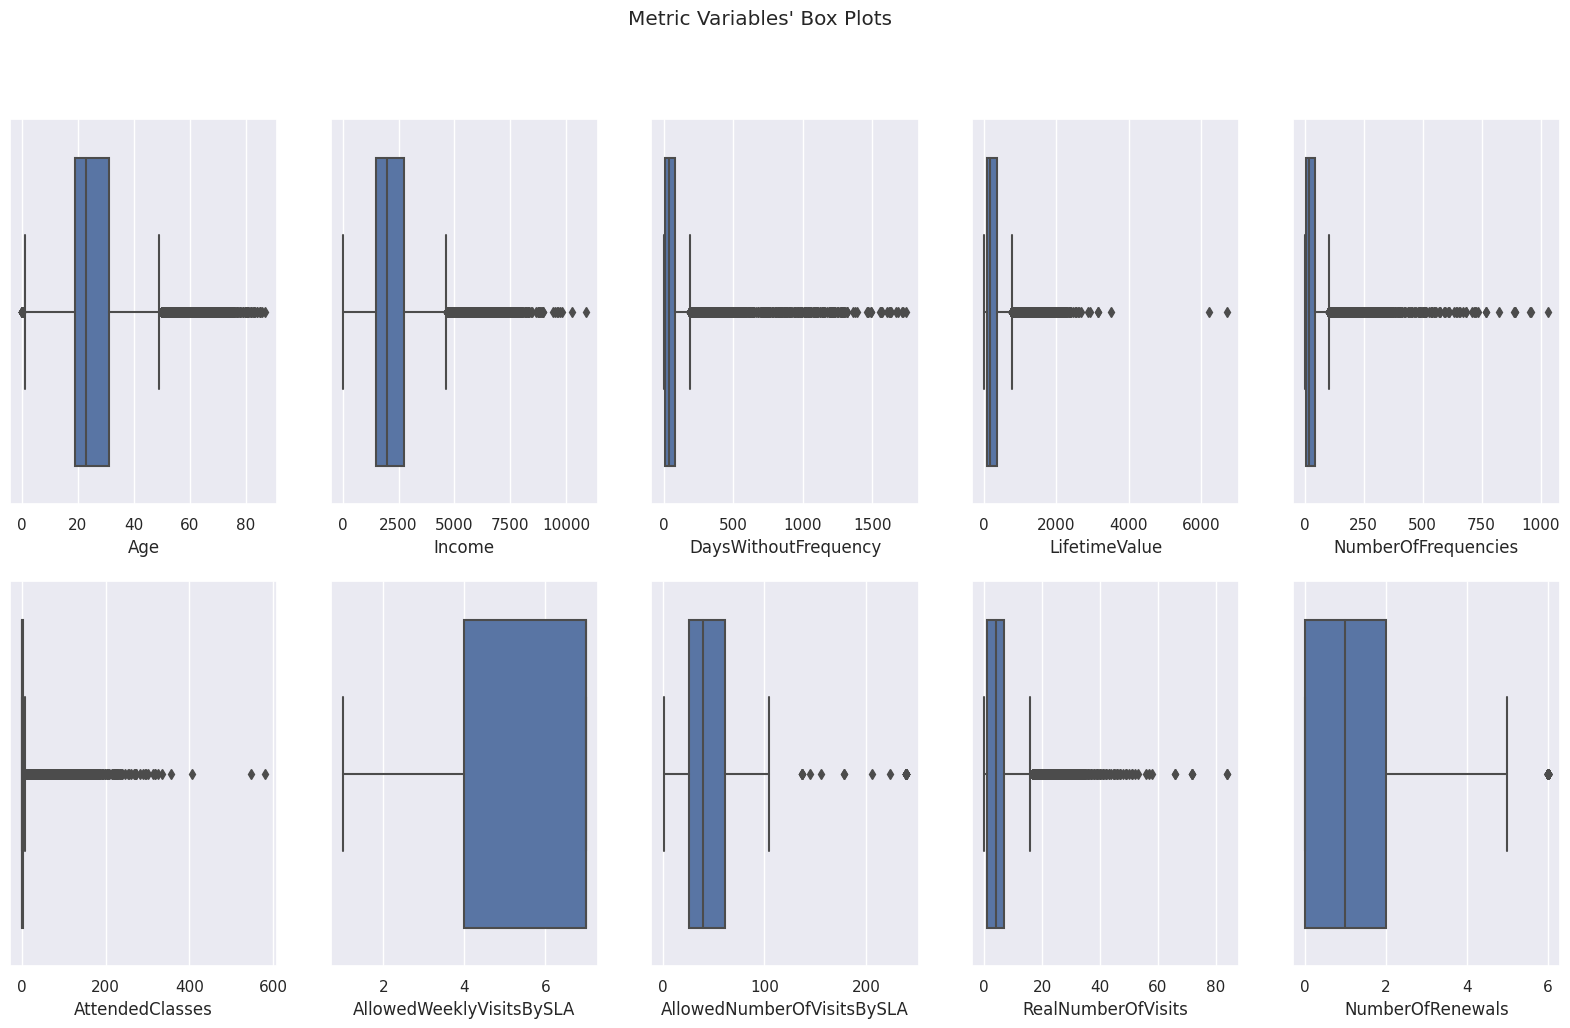

In [33]:
# Check boxplots for all numeric features
sns.set()

fig, axes = plt.subplots(2, floor(len(metric_features) / 2), figsize=(20, 11))
for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x=df[feat], ax=ax)

title = "Metric Variables' Box Plots"

plt.suptitle(title)

plt.show();

In [34]:
# Removing outliers based on visual inspection of the data
filters1 = (
    (df['Age']<=65)                          # Slightly over the 95th percentile to maintain dataset integrity
    &
    (df['DaysWithoutFrequency']<=1300)       # Break in boxplot
    &
    (df['LifetimeValue']<=2000)              # Break in boxplot
    &
    (df['NumberOfFrequencies']<=600)         # Break in boxplot
    &
    (df['AttendedClasses']<=300)             # Break in boxplot
    & 
    (df['AllowedNumberOfVisitsBySLA']<=114)  # Upper Whisker (60.97+(1.5*35.25))
    &
    (df['RealNumberOfVisits']<=40)           # Break in boxplot
    & 
    (df['NumberOfRenewals']!=6)              # Basically non-existent value
)

df_1 = df[filters1]

In [35]:
print('Percentage of data kept after removing outliers:', np.round(df_1.shape[0] / original.shape[0], 4))

Percentage of data kept after removing outliers: 0.9634


In [36]:
# Removing outliers using the IQR method
q25 = df[metric_features].quantile(.25)
q75 = df[metric_features].quantile(.75)
iqr = (q75 - q25)

upper_lim = q75 + 1.5 * iqr
lower_lim = q25 - 1.5 * iqr

filters2 = []
for metric in metric_features:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    filters2.append(df[metric].between(llim, ulim, inclusive='both'))

filters2 = pd.Series(np.all(filters2, 0))
df_2 = df[filters2]
print('Percentage of data kept after removing outliers:', np.round(df_2.shape[0] / original.shape[0], 4))

Percentage of data kept after removing outliers: 0.5519


In [37]:
# Combining both approaches
df_3 = df[(filters1 | filters2)]
print('Percentage of data kept after removing outliers:', np.round(df_3.shape[0] / original.shape[0], 4))

Percentage of data kept after removing outliers: 0.9634


In [38]:
# Get the manual filtering version
df = df_1

## 2.6 Feature Engineering

### 2.6.1 Feature extraction

In [39]:
# Creating Enrollment duration column
df['EnrollmentDuration'] = df['EnrollmentFinish'] - df['EnrollmentStart']
df['EnrollmentDuration'] = df['EnrollmentDuration'].dt.days

In [40]:
# Creating number of Activities column
activities = ['AthleticsActivities','WaterActivities','FitnessActivities',
              'DanceActivities','TeamActivities','RacketActivities', 'NatureActivities',
              'CombatActivities','SpecialActivities','OtherActivities']

df['Activities'] = df[activities].sum(axis=1)

### 2.6.2 Feature Selection

In [41]:
# Removing the ID column
df = df.drop(columns='ID')

#### Updating metric and non-metric features lists

In [42]:
# Update metric features with new engineered features -> 'Activities' & 'EnrollmentDuration'

# Metric Features
metric_features = [
    'Age',
    'EnrollmentDuration',
    'DaysWithoutFrequency',
    'LifetimeValue',
    'NumberOfFrequencies',
    'AttendedClasses',
    'AllowedWeeklyVisitsBySLA',
    'AllowedNumberOfVisitsBySLA',
    'RealNumberOfVisits',
    'NumberOfRenewals',
    'Activities'
]

# Non-Metric Features
non_metric_features = [
    'Gender',
    'UseByTime',
    'AthleticsActivities',
    'WaterActivities',
    'FitnessActivities',
    'DanceActivities',
    'TeamActivities',
    'RacketActivities',
    'CombatActivities',
    'NatureActivities',
    'SpecialActivities',
    'OtherActivities',
    'HasReferences',
    'Dropout'
]

In [43]:
df = df.drop(columns=activities) # Remove column with activities

for activity in activities:
    non_metric_features.remove(activity) # Update non-metric features

## 2.7 Data Normalization

### 2.7.1 Standardization

In [44]:
df_minmax = df.copy()

In [45]:
# Use MinMaxScaler to scale the data
scaler = MinMaxScaler()
scaled_feat = scaler.fit_transform(df_minmax[metric_features])

In [46]:
# Using MinMaxScaler to scale the data
df_minmax[metric_features] = scaled_feat
df_minmax.head()

Age  Gender  Income EnrollmentStart EnrollmentFinish LastPeriodStart  \
0  0.923077  Female  5500.0      2019-09-03       2019-10-31      2019-07-01   
1  0.446154  Female  2630.0      2014-08-12       2015-09-14      2015-01-01   
2  0.353846    Male  1980.0      2017-05-02       2017-06-01      2017-01-01   
3  0.138462    Male     0.0      2018-09-05       2019-02-12      2018-07-01   
4  0.538462    Male  4320.0      2016-04-20       2018-06-07      2018-01-01   

  LastPeriodFinish DateLastVisit  DaysWithoutFrequency  LifetimeValue  ...  \
0       2019-12-31    2019-10-30              0.000777       0.044818  ...   
1       2015-12-31    2015-07-16              0.046620       0.240369  ...   
2       2017-06-30    2017-05-25              0.005439       0.018860  ...   
3       2019-06-30    2019-01-21              0.017094       0.077949  ...   
4       2018-06-30    2017-11-09              0.163170       0.187199  ...   

   AttendedClasses  AllowedWeeklyVisitsBySLA  AllowedNumberOfVisitsBySLA  \
0         0.023333                  1.000000                    0.055228   
1         0.003333                  0.166667                    0.162788   
2         0.000000                  1.000000                    0.284542   
3         0.006667                  0.166667                    0.165685   
4         0.000000                  1.000000                    0.583277   

   RealNumberOfVisits  NumberOfRenewals  HasReferences  NumberOfReferences  \
0               0.050               0.0            0.0                   0   
1               0.025               0.4            0.0                   0   
2               0.150               0.0            0.0                   0   
3               0.075               0.0            0.0                   0   
4               0.000               0.6            0.0                   0   

   Dropout  EnrollmentDuration  Activities  
0        0            0.030917         0.2  
1        1            0.212154         0.2  
2        1            0.015991         0.2  
3        1            0.085288         0.2  
4        1            0.414712         0.2  

[5 rows x 22 columns]

In [47]:
df_standard = df.copy()

In [48]:
# Using StandardScaler to scale the data
scaler = StandardScaler()
scaled_feat = scaler.fit_transform(df_standard[metric_features])

In [49]:
df_standard[metric_features] = scaled_feat
df_standard.head()

Age  Gender  Income EnrollmentStart EnrollmentFinish LastPeriodStart  \
0  2.781439  Female  5500.0      2019-09-03       2019-10-31      2019-07-01   
1  0.312537  Female  2630.0      2014-08-12       2015-09-14      2015-01-01   
2 -0.165315    Male  1980.0      2017-05-02       2017-06-01      2017-01-01   
3 -1.280302    Male     0.0      2018-09-05       2019-02-12      2018-07-01   
4  0.790389    Male  4320.0      2016-04-20       2018-06-07      2018-01-01   

  LastPeriodFinish DateLastVisit  DaysWithoutFrequency  LifetimeValue  ...  \
0       2019-12-31    2019-10-30             -0.598869      -0.609583  ...   
1       2015-12-31    2015-07-16             -0.146076       0.607136  ...   
2       2017-06-30    2017-05-25             -0.552822      -0.771094  ...   
3       2019-06-30    2019-01-21             -0.437705      -0.403441  ...   
4       2018-06-30    2017-11-09              1.005091       0.276311  ...   

   AttendedClasses  AllowedWeeklyVisitsBySLA  AllowedNumberOfVisitsBySLA  \
0        -0.091148                  0.570620                   -1.788136   
1        -0.325084                 -1.815529                   -1.217889   
2        -0.364073                  0.570620                   -0.572393   
3        -0.286095                 -1.815529                   -1.202532   
4        -0.364073                  0.570620                    1.011401   

   RealNumberOfVisits  NumberOfRenewals  HasReferences  NumberOfReferences  \
0           -0.547524         -0.877847            0.0                   0   
1           -0.723547          0.655722            0.0                   0   
2            0.156568         -0.877847            0.0                   0   
3           -0.371501         -0.877847            0.0                   0   
4           -0.899570          1.422507            0.0                   0   

   Dropout  EnrollmentDuration  Activities  
0        0           -0.681703   -0.283048  
1        1            0.307262   -0.283048  
2        1           -0.763147   -0.283048  
3        1           -0.385013   -0.283048  
4        1            1.412576   -0.283048  

[5 rows x 22 columns]

In [50]:
# We'll keep the features scaled with Standard Scaler
df = df_standard.copy()

### 2.7.2 One Hot Encoding

In [51]:
df_ohc = df.copy()

In [52]:
# Using OneHotEncoder to encode the categorical features
ohc = OneHotEncoder(sparse_output=False, drop="first")
ohc_feat = ohc.fit_transform(df_ohc[non_metric_features])
ohc_feat_names = ohc.get_feature_names_out()
ohc_df = pd.DataFrame(ohc_feat, index=df_ohc.index, columns=ohc_feat_names)
ohc_df

Gender_Male  UseByTime_1  HasReferences_1.0  Dropout_1
0              0.0          0.0                0.0        0.0
1              0.0          0.0                0.0        1.0
2              1.0          0.0                0.0        1.0
3              1.0          0.0                0.0        1.0
4              1.0          0.0                0.0        1.0
...            ...          ...                ...        ...
14937          1.0          0.0                0.0        0.0
14938          1.0          0.0                0.0        1.0
14939          1.0          0.0                0.0        1.0
14940          1.0          0.0                0.0        0.0
14941          0.0          0.0                0.0        1.0

[14395 rows x 4 columns]

In [53]:
# Reassigning df to contain ohc variables
df_ohc = pd.concat([df_ohc.drop(columns=non_metric_features), ohc_df], axis=1)
df_ohc.head()

Age  Income EnrollmentStart EnrollmentFinish LastPeriodStart  \
0  2.781439  5500.0      2019-09-03       2019-10-31      2019-07-01   
1  0.312537  2630.0      2014-08-12       2015-09-14      2015-01-01   
2 -0.165315  1980.0      2017-05-02       2017-06-01      2017-01-01   
3 -1.280302     0.0      2018-09-05       2019-02-12      2018-07-01   
4  0.790389  4320.0      2016-04-20       2018-06-07      2018-01-01   

  LastPeriodFinish DateLastVisit  DaysWithoutFrequency  LifetimeValue  \
0       2019-12-31    2019-10-30             -0.598869      -0.609583   
1       2015-12-31    2015-07-16             -0.146076       0.607136   
2       2017-06-30    2017-05-25             -0.552822      -0.771094   
3       2019-06-30    2019-01-21             -0.437705      -0.403441   
4       2018-06-30    2017-11-09              1.005091       0.276311   

   NumberOfFrequencies  ...  AllowedNumberOfVisitsBySLA  RealNumberOfVisits  \
0            -0.511846  ...                   -1.788136           -0.547524   
1            -0.253448  ...                   -1.217889           -0.723547   
2            -0.567216  ...                   -0.572393            0.156568   
3            -0.308819  ...                   -1.202532           -0.371501   
4             0.078777  ...                    1.011401           -0.899570   

   NumberOfRenewals  NumberOfReferences  EnrollmentDuration  Activities  \
0         -0.877847                   0           -0.681703   -0.283048   
1          0.655722                   0            0.307262   -0.283048   
2         -0.877847                   0           -0.763147   -0.283048   
3         -0.877847                   0           -0.385013   -0.283048   
4          1.422507                   0            1.412576   -0.283048   

   Gender_Male  UseByTime_1  HasReferences_1.0  Dropout_1  
0          0.0          0.0                0.0        0.0  
1          0.0          0.0                0.0        1.0  
2          1.0          0.0                0.0        1.0  
3          1.0          0.0                0.0        1.0  
4          1.0          0.0                0.0        1.0  

[5 rows x 22 columns]

In [54]:
df = df_ohc.copy()

In [55]:
# Rename OHE columns from "feature_val_a" to "x_feature_val_a"
rename_ohe_cols = {}

for i in non_metric_features:
    for j in df.columns[df.columns.str.startswith(i)].to_list() :
        rename_ohe_cols[j] = 'x_' + j

df.rename(columns=rename_ohe_cols, inplace=True)

In [56]:
# Update non-metric features given one hot encoding
non_metric_features = df.columns[df.columns.str.startswith('x')]

In [57]:
non_metric_features

Index(['x_Gender_Male', 'x_UseByTime_1', 'x_HasReferences_1.0', 'x_Dropout_1'], dtype='object')

# 3. Cluster Analysis

## 3.1 Dimensionality Reduction

### PCA

In [58]:
df_pca = df.copy()

In [59]:
# Use PCA to reduce dimensionality of data
pca = PCA()
pca_feat = pca.fit_transform(df_pca[metric_features])

- **How many Principal Components to retain?**

In [60]:
# Output PCA table
pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
)

Eigenvalue  Difference  Proportion  Cumulative
1     3.202651    0.000000    0.291130    0.291130
2     2.101067   -1.101584    0.190993    0.482123
3     1.483504   -0.617563    0.134855    0.616977
4     0.937335   -0.546169    0.085206    0.702184
5     0.792579   -0.144756    0.072048    0.774231
6     0.742526   -0.050054    0.067498    0.841729
7     0.597630   -0.144896    0.054326    0.896055
8     0.410249   -0.187381    0.037293    0.933348
9     0.306338   -0.103911    0.027847    0.961195
10    0.279097   -0.027241    0.025371    0.986566
11    0.147790   -0.131307    0.013434    1.000000

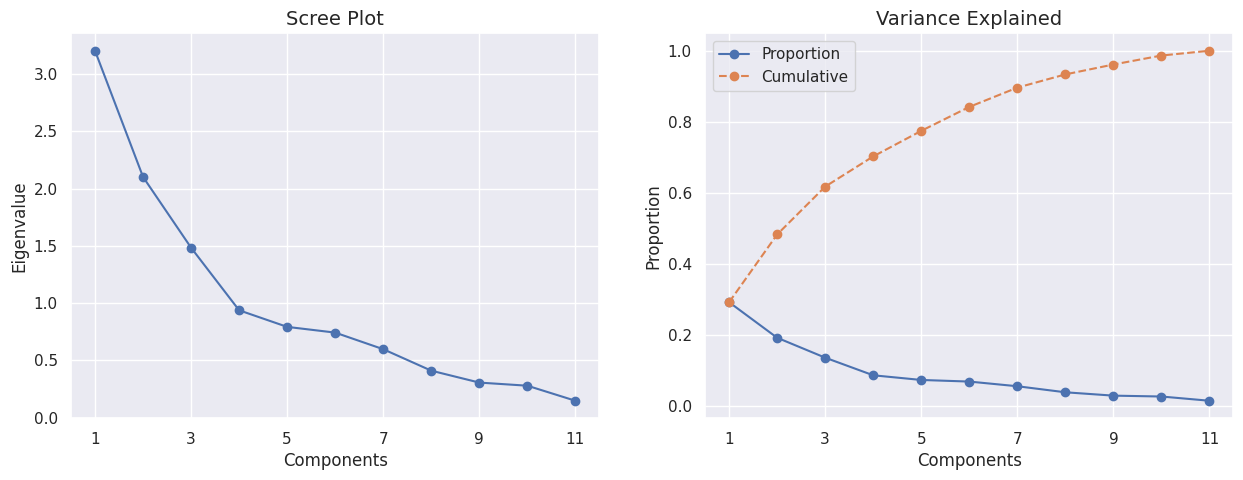

In [61]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# draw plots
ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")

# customizations
ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show();

In [62]:
# Performing PCA again, but with only the number of components to explain most of the variance
pca = PCA(n_components=4)
pca_feat = pca.fit_transform(df_pca[metric_features])
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_feat, index=df_pca.index, columns=pca_feat_names)
pca_df

PC0       PC1       PC2       PC3
0     -1.240597 -0.252486 -0.346854  0.549736
1      1.109608 -1.462204  0.516578  0.036514
2     -1.442274 -0.583861 -0.732964  0.128767
3     -0.148667 -2.487185 -0.470325  0.175296
4      0.558926  1.452820  2.081155 -0.735828
...         ...       ...       ...       ...
14937  4.558745 -0.594822 -2.055456 -0.518000
14938 -0.853119  1.110823 -0.225566 -0.119636
14939 -1.395887 -0.572462 -0.943938  0.065625
14940  4.684926 -0.320138 -2.595041 -0.298293
14941  3.092611  3.348069 -0.045353 -1.197921

[14395 rows x 4 columns]

In [63]:
# Reassigning df to contain pca variables
df_pca = pd.concat([df_pca, pca_df], axis=1)
df_pca.head()

Age  Income EnrollmentStart EnrollmentFinish LastPeriodStart  \
0  2.781439  5500.0      2019-09-03       2019-10-31      2019-07-01   
1  0.312537  2630.0      2014-08-12       2015-09-14      2015-01-01   
2 -0.165315  1980.0      2017-05-02       2017-06-01      2017-01-01   
3 -1.280302     0.0      2018-09-05       2019-02-12      2018-07-01   
4  0.790389  4320.0      2016-04-20       2018-06-07      2018-01-01   

  LastPeriodFinish DateLastVisit  DaysWithoutFrequency  LifetimeValue  \
0       2019-12-31    2019-10-30             -0.598869      -0.609583   
1       2015-12-31    2015-07-16             -0.146076       0.607136   
2       2017-06-30    2017-05-25             -0.552822      -0.771094   
3       2019-06-30    2019-01-21             -0.437705      -0.403441   
4       2018-06-30    2017-11-09              1.005091       0.276311   

   NumberOfFrequencies  ...  EnrollmentDuration  Activities  x_Gender_Male  \
0            -0.511846  ...           -0.681703   -0.283048            0.0   
1            -0.253448  ...            0.307262   -0.283048            0.0   
2            -0.567216  ...           -0.763147   -0.283048            1.0   
3            -0.308819  ...           -0.385013   -0.283048            1.0   
4             0.078777  ...            1.412576   -0.283048            1.0   

   x_UseByTime_1  x_HasReferences_1.0  x_Dropout_1       PC0       PC1  \
0            0.0                  0.0          0.0 -1.240597 -0.252486   
1            0.0                  0.0          1.0  1.109608 -1.462204   
2            0.0                  0.0          1.0 -1.442274 -0.583861   
3            0.0                  0.0          1.0 -0.148667 -2.487185   
4            0.0                  0.0          1.0  0.558926  1.452820   

        PC2       PC3  
0 -0.346854  0.549736  
1  0.516578  0.036514  
2 -0.732964  0.128767  
3 -0.470325  0.175296  
4  2.081155 -0.735828  

[5 rows x 26 columns]

- **How to interpret each Principal Component?**

In [64]:
def _color_red_or_green(val):
    if val < -0.45:
        color = 'background-color: red'
    elif val > 0.45:
        color = 'background-color: green'
    else:
        color = ''
    return color

# Interpreting each Principal Component
loadings = df_pca[metric_features + pca_feat_names].corr().loc[metric_features, pca_feat_names]
loadings.style.applymap(_color_red_or_green)

In [65]:
df = df_pca.copy()

In [66]:
# Group PC features
pc_features = df.columns[df.columns.str.startswith('PC')]

## Final Preprocessed Data

In [67]:
df

Age  Income EnrollmentStart EnrollmentFinish LastPeriodStart  \
0      2.781439  5500.0      2019-09-03       2019-10-31      2019-07-01   
1      0.312537  2630.0      2014-08-12       2015-09-14      2015-01-01   
2     -0.165315  1980.0      2017-05-02       2017-06-01      2017-01-01   
3     -1.280302     0.0      2018-09-05       2019-02-12      2018-07-01   
4      0.790389  4320.0      2016-04-20       2018-06-07      2018-01-01   
...         ...     ...             ...              ...             ...   
14937 -0.882092     0.0      2016-09-08       2016-09-08      2019-07-01   
14938  1.108957  1990.0      2015-09-17       2016-06-04      2016-01-01   
14939 -0.404241  1810.0      2017-03-01       2017-03-31      2017-01-01   
14940  2.383229  4800.0      2018-03-01       2018-03-01      2019-07-01   
14941  0.551463  3700.0      2016-04-01       2019-06-11      2019-01-01   

      LastPeriodFinish DateLastVisit  DaysWithoutFrequency  LifetimeValue  \
0           2019-12-31    2019-10-30             -0.598869      -0.609583   
1           2015-12-31    2015-07-16             -0.146076       0.607136   
2           2017-06-30    2017-05-25             -0.552822      -0.771094   
3           2019-06-30    2019-01-21             -0.437705      -0.403441   
4           2018-06-30    2017-11-09              1.005091       0.276311   
...                ...           ...                   ...            ...   
14937       2019-12-31    2019-10-29             -0.591194       3.669609   
14938       2016-06-30    2016-04-27             -0.314914       0.184709   
14939       2017-06-30    2017-03-29             -0.591194      -0.752368   
14940       2019-12-31    2019-10-28             -0.583520       1.572771   
14941       2019-06-30    2019-05-28             -0.499101       1.981621   

       NumberOfFrequencies  ...  EnrollmentDuration  Activities  \
0                -0.511846  ...           -0.681703   -0.283048   
1                -0.253448  ...            0.307262   -0.283048   
2                -0.567216  ...           -0.763147   -0.283048   
3                -0.308819  ...           -0.385013   -0.283048   
4                 0.078777  ...            1.412576   -0.283048   
...                    ...  ...                 ...         ...   
14937             1.389221  ...           -0.850409   -0.283048   
14938             0.374088  ...           -0.091233   -0.283048   
14939            -0.567216  ...           -0.763147   -0.283048   
14940             2.736579  ...           -0.850409   -0.283048   
14941             2.441267  ...            2.541159   -0.283048   

       x_Gender_Male  x_UseByTime_1  x_HasReferences_1.0  x_Dropout_1  \
0                0.0            0.0                  0.0          0.0   
1                0.0            0.0                  0.0          1.0   
2                1.0            0.0                  0.0          1.0   
3                1.0            0.0                  0.0          1.0   
4                1.0            0.0                  0.0          1.0   
...              ...            ...                  ...          ...   
14937            1.0            0.0                  0.0          0.0   
14938            1.0            0.0                  0.0          1.0   
14939            1.0            0.0                  0.0          1.0   
14940            1.0            0.0                  0.0          0.0   
14941            0.0            0.0                  0.0          1.0   

            PC0       PC1       PC2       PC3  
0     -1.240597 -0.252486 -0.346854  0.549736  
1      1.109608 -1.462204  0.516578  0.036514  
2     -1.442274 -0.583861 -0.732964  0.128767  
3     -0.148667 -2.487185 -0.470325  0.175296  
4      0.558926  1.452820  2.081155 -0.735828  
...         ...       ...       ...       ...  
14937  4.558745 -0.594822 -2.055456 -0.518000  
14938 -0.853119  1.110823 -0.225566 -0.119636  
14939 -1.395887 -0.572462 -0.943938  0.065625  
14940  4.684

## 3.2 Clustering

### Hierarchical Clustering

In [69]:
# Performing HC
hclust = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=5)
hc_labels = hclust.fit_predict(df[metric_features])
hc_labels

array([2, 1, 2, ..., 2, 3, 0])

In [70]:
# Characterizing the clusters
df_concat = pd.concat((df, pd.Series(hc_labels, name='labels', index=df.index)), axis=1)
df_concat.groupby('labels').mean()

Age       Income  DaysWithoutFrequency  LifetimeValue  \
labels                                                               
0       0.411666  2664.082447              0.768112       0.843649   
1      -0.573697  1426.240889             -0.050171       0.209573   
2       0.132457  2339.673601             -0.082187      -0.466671   
3      -0.586964  1313.996656             -0.344098       2.836905   
4       0.264129  2468.234733             -0.112134       0.318835   

        NumberOfFrequencies  AttendedClasses  AllowedWeeklyVisitsBySLA  \
labels                                                                   
0                  1.330500        -0.274170                  0.465274   
1                 -0.233691         0.415214                 -1.649053   
2                 -0.295899        -0.356303                  0.569023   
3                  1.528821         3.802641                 -1.456409   
4                  0.222188        -0.074183                  0.155321   

        AllowedNumberOfVisitsBySLA  RealNumberOfVisits  NumberOfRenewals  ...  \
labels                                                                    ...   
0                         0.530931            0.344412          1.477569  ...   
1                        -1.106350           -0.319140          0.015360  ...   
2                         0.344036            0.046207         -0.457143  ...   
3                        -0.972305            0.178056          1.746916  ...   
4                         0.088546           -0.087311          0.488903  ...   

        EnrollmentDuration  Activities  x_Gender_Male  x_UseByTime_1  \
labels                                                                 
0                 1.302031   -0.065075       0.488697       0.134973   
1                -0.033943   -0.299303       0.405415       0.006942   
2                -0.306065   -0.283421       0.375060       0.041607   
3                 0.215326    0.071985       0.449833       0.015050   
4                 0.544561    3.137072       0.461832       0.089695   

        x_HasReferences_1.0  x_Dropout_1       PC0       PC1       PC2  \
labels                                                                   
0                  0.011968     0.735372  1.599348  1.852662  0.917588   
1                  0.041999     0.785491  0.867307 -1.885648 -0.062558   
2                  0.004185     0.866930 -1.064866  0.251296 -0.141369   
3                  0.118729     0.342809  5.114230 -0.936201 -1.213904   
4                  0.022901     0.804389  0.900860  1.053584  0.676055   

             PC3  
labels            
0      -0.754848  
1      -0.076555  
2      -0.172393  
3      -0.277008  
4       2.827663  

[5 rows x 21 columns]

- **What's the most appropriate Linkage Method?**

In [71]:
# Computing SST
X = df[metric_features].values
sst = np.sum(np.square(X - X.mean(axis=0)), axis=0)

# Computing SSW
ssw_iter = []
for i in np.unique(hc_labels):
    X_k = X[hc_labels == i]
    ssw_iter.append(np.sum(np.square(X_k - X_k.mean(axis=0)), axis=0))
ssw = np.sum(ssw_iter, axis=0)

# Computing SSB
ssb_iter = []
for i in np.unique(hc_labels):
    X_k = X[hc_labels == i]
    ssb_iter.append(X_k.shape[0] * np.square(X_k.mean(axis=0) - X.mean(axis=0)))
ssb = np.sum(ssb_iter, axis=0)

In [72]:
def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """This function computes the R2 for a set of cluster solutions given by the application of a hierarchical method.
    The R2 is a measure of the homogenity of a cluster solution. It is based on SSt = SSw + SSb and R2 = SSb/SSt.

    Parameters:
    df (DataFrame): Dataset to apply clustering
    link_method (str): either "ward", "complete", "average", "single"
    max_nclus (int): maximum number of clusters to compare the methods
    min_nclus (int): minimum number of clusters to compare the methods. Defaults to 1.
    dist (str): distance to use to compute the clustering solution. Must be a valid distance. Defaults to "euclidean".

    Returns:
    ndarray: R2 values for the range of cluster solutions
    """
    def get_ss(df):
        ss = np.sum(df.var() * (df.count() - 1))
        return ss  # return sum of sum of squares of each df variable

    sst = get_ss(df)  # get total sum of squares

    r2 = []  # where we will store the R2 metrics for each cluster solution

    for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
        cluster = AgglomerativeClustering(n_clusters=i, metric=dist, linkage=link_method)


        # get cluster labels
        hclabels = cluster.fit_predict(df)


        # concat df with labels
        df_concat = pd.concat((df, pd.Series(hclabels, name='labels', index=df.index)), axis=1)


        # compute ssw for each cluster labels
        ssw_labels = df_concat.groupby(by='labels').apply(get_ss)


        # remember: SST = SSW + SSB
        ssb = sst - np.sum(ssw_labels)


        r2.append(ssb / sst)  # save the R2 of the given cluster solution

    return np.array(r2)

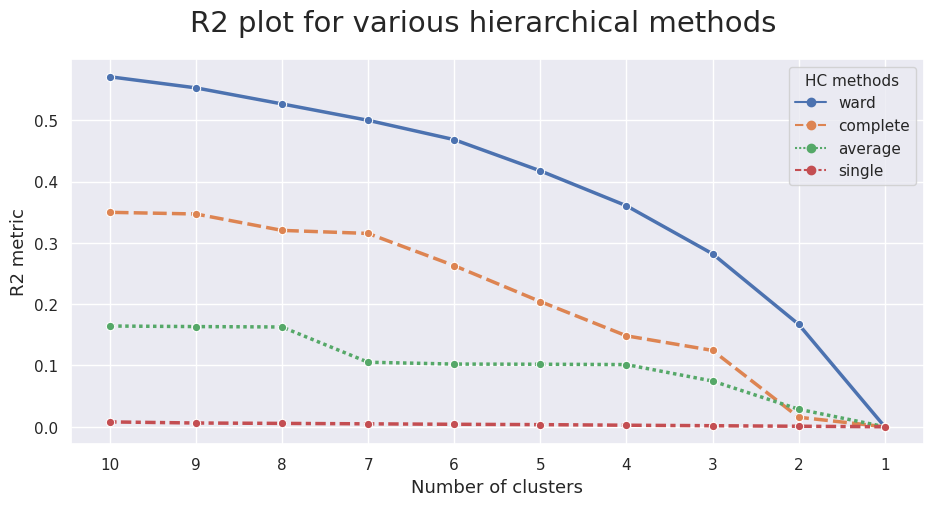

In [73]:
# Prepare input
hc_methods = ["ward", "complete", "average", "single"]
# Call function defined above to obtain the R2 statistic for each hc_method
max_nclus = 10
r2_hc_methods = np.vstack(
    [
        get_r2_hc(df=df[metric_features], link_method=link, max_nclus=max_nclus)
        for link in hc_methods
    ]
).T
r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
plt.gca().invert_xaxis()  # invert x axis
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

plt.show();

- **Defining the number of clusters**

In [74]:
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, metric=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(df[metric_features])

array([10249,  9587, 14117, ...,     2,     1,     0])

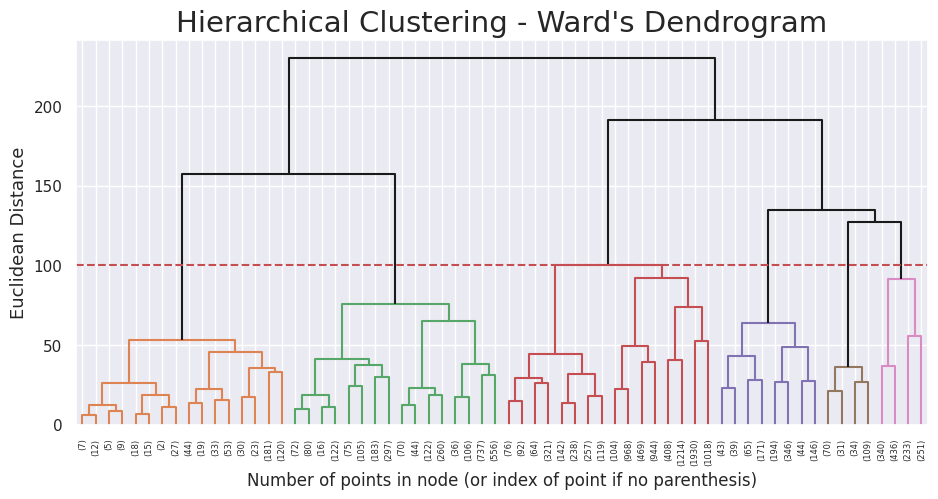

In [75]:
# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

for i, merge in enumerate(hclust.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 100
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show();

- **Test cluster solutions**

In [76]:
# 5 cluster solution
linkage = 'ward'
distance = 'euclidean'
hc5lust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=5)
hc5_labels = hc5lust.fit_predict(df[metric_features])

In [77]:
# Characterizing the 5 clusters
df_concat = pd.concat((df, pd.Series(hc5_labels, name='labels', index=df.index)), axis=1)
df_concat.groupby('labels').mean()

Age       Income  DaysWithoutFrequency  LifetimeValue  \
labels                                                               
0       0.411666  2664.082447              0.768112       0.843649   
1      -0.573697  1426.240889             -0.050171       0.209573   
2       0.132457  2339.673601             -0.082187      -0.466671   
3      -0.586964  1313.996656             -0.344098       2.836905   
4       0.264129  2468.234733             -0.112134       0.318835   

        NumberOfFrequencies  AttendedClasses  AllowedWeeklyVisitsBySLA  \
labels                                                                   
0                  1.330500        -0.274170                  0.465274   
1                 -0.233691         0.415214                 -1.649053   
2                 -0.295899        -0.356303                  0.569023   
3                  1.528821         3.802641                 -1.456409   
4                  0.222188        -0.074183                  0.155321   

        AllowedNumberOfVisitsBySLA  RealNumberOfVisits  NumberOfRenewals  ...  \
labels                                                                    ...   
0                         0.530931            0.344412          1.477569  ...   
1                        -1.106350           -0.319140          0.015360  ...   
2                         0.344036            0.046207         -0.457143  ...   
3                        -0.972305            0.178056          1.746916  ...   
4                         0.088546           -0.087311          0.488903  ...   

        EnrollmentDuration  Activities  x_Gender_Male  x_UseByTime_1  \
labels                                                                 
0                 1.302031   -0.065075       0.488697       0.134973   
1                -0.033943   -0.299303       0.405415       0.006942   
2                -0.306065   -0.283421       0.375060       0.041607   
3                 0.215326    0.071985       0.449833       0.015050   
4                 0.544561    3.137072       0.461832       0.089695   

        x_HasReferences_1.0  x_Dropout_1       PC0       PC1       PC2  \
labels                                                                   
0                  0.011968     0.735372  1.599348  1.852662  0.917588   
1                  0.041999     0.785491  0.867307 -1.885648 -0.062558   
2                  0.004185     0.866930 -1.064866  0.251296 -0.141369   
3                  0.118729     0.342809  5.114230 -0.936201 -1.213904   
4                  0.022901     0.804389  0.900860  1.053584  0.676055   

             PC3  
labels            
0      -0.754848  
1      -0.076555  
2      -0.172393  
3      -0.277008  
4       2.827663  

[5 rows x 21 columns]

In [78]:
# 7 cluster solution
linkage = 'ward'
distance = 'euclidean'
hc7lust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=7)
hc7_labels = hc7lust.fit_predict(df[metric_features])

In [79]:
# Characterizing the 7 clusters
df_concat = pd.concat((df, pd.Series(hc7_labels, name='labels', index=df.index)), axis=1)
df_concat.groupby('labels').mean()

Age       Income  DaysWithoutFrequency  LifetimeValue  \
labels                                                               
0       0.119613  2322.408221             -0.022366      -0.478495   
1      -0.573697  1426.240889             -0.050171       0.209573   
2       0.480860  2751.611111             -0.177231       0.972209   
3      -0.586964  1313.996656             -0.344098       2.836905   
4       0.264129  2468.234733             -0.112134       0.318835   
5       0.054354  2212.090164              5.649801       0.179773   
6       0.201684  2432.727273             -0.404598      -0.402943   

        NumberOfFrequencies  AttendedClasses  AllowedWeeklyVisitsBySLA  \
labels                                                                   
0                 -0.361103        -0.357298                  0.569065   
1                 -0.233691         0.415214                 -1.649053   
2                  1.623082        -0.303887                  0.556228   
3                  1.528821         3.802641                 -1.456409   
4                  0.222188        -0.074183                  0.155321   
5                 -0.180377        -0.120709                 -0.004402   
6                  0.055526        -0.350938                  0.568797   

        AllowedNumberOfVisitsBySLA  RealNumberOfVisits  NumberOfRenewals  ...  \
labels                                                                    ...   
0                         0.312288           -0.271875         -0.448752  ...   
1                        -1.106350           -0.319140          0.015360  ...   
2                         0.618400            0.475645          1.471192  ...   
3                        -0.972305            0.178056          1.746916  ...   
4                         0.088546           -0.087311          0.488903  ...   
5                         0.079247           -0.333266          1.510499  ...   
6                         0.515147            1.760542         -0.502363  ...   

        EnrollmentDuration  Activities  x_Gender_Male  x_UseByTime_1  \
labels                                                                 
0                -0.284727   -0.283048       0.364564       0.041673   
1                -0.033943   -0.299303       0.405415       0.006942   
2                 1.323700   -0.119504       0.496825       0.161111   
3                 0.215326    0.071985       0.449833       0.015050   
4                 0.544561    3.137072       0.461832       0.089695   
5                 1.190130    0.215992       0.446721       0.000000   
6                -0.421073   -0.285433       0.431627       0.041253   

        x_HasReferences_1.0  x_Dropout_1       PC0       PC1       PC2  \
labels                                                                   
0                  0.004252     0.887881 -1.094582  0.120001  0.079857   
1                  0.041999     0.785491  0.867307 -1.885648 -0.062558   
2                  0.011111     0.745238  1.692676  2.119127  0.192940   
3                  0.118729     0.342809  5.114230 -0.936201 -1.213904   
4                  0.022901     0.804389  0.900860  1.053584  0.676055   
5                  0.016393     0.684426  1.117406  0.476658  4.659624   
6                  0.003820     0.754011 -0.904710  0.958926 -1.333692   

             PC3  
labels            
0      -0.130202  
1      -0.076555  
2      -0.634519  
3      -0.277008  
4       2.827663  
5      -1.376219  
6      -0.399783  

[7 rows x 21 columns]

In [80]:
## Let's put both HC5 and HC7 labels in the same df to compare

df_hc5_hc7 = pd.concat((df,
                        pd.Series(hc5_labels,
                                  name='hc5_labels',
                                  index=df.index),
                        pd.Series(hc7_labels,
                                  name='hc7_labels',
                                  index=df.index)
                        ), axis=1)

In [81]:
## See crosstab of 5 vs 7

pd.crosstab(df_hc5_hc7['hc7_labels'],
           df_hc5_hc7['hc5_labels'])

hc5_labels     0     1     2    3     4
hc7_labels                             
0              0     0  7055    0     0
1              0  2881     0    0     0
2           1260     0     0    0     0
3              0     0     0  598     0
4              0     0     0    0  1048
5            244     0     0    0     0
6              0     0  1309    0     0

- **Final Hierarchical clustering solution**

In [82]:
# final cluster solution
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=7)
hc_labels = hclust.fit_predict(df[metric_features])

In [83]:
# Characterizing the final clusters
df_concat = pd.concat((df, pd.Series(hc_labels, name='labels', index=df.index)), axis=1)
df_concat.groupby('labels').mean()

Age       Income  DaysWithoutFrequency  LifetimeValue  \
labels                                                               
0       0.119613  2322.408221             -0.022366      -0.478495   
1      -0.573697  1426.240889             -0.050171       0.209573   
2       0.480860  2751.611111             -0.177231       0.972209   
3      -0.586964  1313.996656             -0.344098       2.836905   
4       0.264129  2468.234733             -0.112134       0.318835   
5       0.054354  2212.090164              5.649801       0.179773   
6       0.201684  2432.727273             -0.404598      -0.402943   

        NumberOfFrequencies  AttendedClasses  AllowedWeeklyVisitsBySLA  \
labels                                                                   
0                 -0.361103        -0.357298                  0.569065   
1                 -0.233691         0.415214                 -1.649053   
2                  1.623082        -0.303887                  0.556228   
3                  1.528821         3.802641                 -1.456409   
4                  0.222188        -0.074183                  0.155321   
5                 -0.180377        -0.120709                 -0.004402   
6                  0.055526        -0.350938                  0.568797   

        AllowedNumberOfVisitsBySLA  RealNumberOfVisits  NumberOfRenewals  ...  \
labels                                                                    ...   
0                         0.312288           -0.271875         -0.448752  ...   
1                        -1.106350           -0.319140          0.015360  ...   
2                         0.618400            0.475645          1.471192  ...   
3                        -0.972305            0.178056          1.746916  ...   
4                         0.088546           -0.087311          0.488903  ...   
5                         0.079247           -0.333266          1.510499  ...   
6                         0.515147            1.760542         -0.502363  ...   

        EnrollmentDuration  Activities  x_Gender_Male  x_UseByTime_1  \
labels                                                                 
0                -0.284727   -0.283048       0.364564       0.041673   
1                -0.033943   -0.299303       0.405415       0.006942   
2                 1.323700   -0.119504       0.496825       0.161111   
3                 0.215326    0.071985       0.449833       0.015050   
4                 0.544561    3.137072       0.461832       0.089695   
5                 1.190130    0.215992       0.446721       0.000000   
6                -0.421073   -0.285433       0.431627       0.041253   

        x_HasReferences_1.0  x_Dropout_1       PC0       PC1       PC2  \
labels                                                                   
0                  0.004252     0.887881 -1.094582  0.120001  0.079857   
1                  0.041999     0.785491  0.867307 -1.885648 -0.062558   
2                  0.011111     0.745238  1.692676  2.119127  0.192940   
3                  0.118729     0.342809  5.114230 -0.936201 -1.213904   
4                  0.022901     0.804389  0.900860  1.053584  0.676055   
5                  0.016393     0.684426  1.117406  0.476658  4.659624   
6                  0.003820     0.754011 -0.904710  0.958926 -1.333692   

             PC3  
labels            
0      -0.130202  
1      -0.076555  
2      -0.634519  
3      -0.277008  
4       2.827663  
5      -1.376219  
6      -0.399783  

[7 rows x 21 columns]

In [84]:
cluster_means = df_concat.groupby('labels').mean()[metric_features].T
cluster_means.style.format(precision=2).background_gradient(axis=1)

## K-means Clustering

In [85]:
# Test k-means clustering
df_kmeans = df.copy()

In [86]:
inertia1 = []
num_clusters1 = range(1,11)

for i in num_clusters1:
    cluster_centers1, inertia = kmeans(df_kmeans[metric_features],i)
    inertia1.append(inertia)

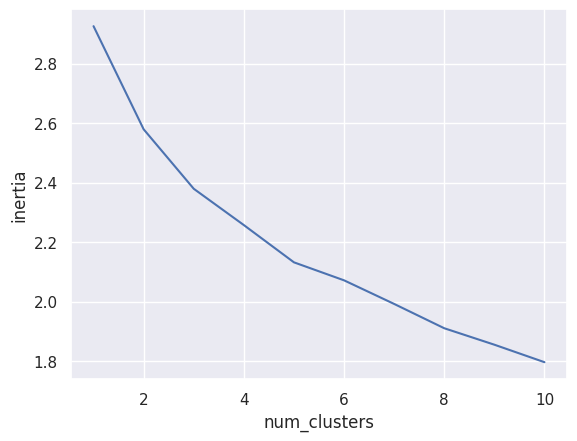

In [87]:
elbow_data1 = pd.DataFrame({'num_clusters': num_clusters1,'inertia': inertia1})
sns.lineplot(x='num_clusters',y='inertia',data=elbow_data1)
plt.show()

In [88]:
cluster_centers1, _ = kmeans(df_kmeans[metric_features],5)
df_kmeans['cluster_labels'],_ = vq(df_kmeans[metric_features],cluster_centers1)
df_kmeans['cluster_labels'].value_counts()

2    5480
0    3666
3    2618
4    1834
1     797
Name: cluster_labels, dtype: int64

In [89]:
cluster_kmeans = df_kmeans.groupby('cluster_labels').mean()[metric_features].T
cluster_kmeans.style.format(precision=2).background_gradient(axis=1)

## Self Organizing Maps

In [90]:
df_som = df.copy()

In [91]:
sm = sompy.SOMFactory().build(
    df_som[metric_features].values,
    mapsize=[50, 50],
    initialization='pca',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=metric_features
)

sm.train(n_job=-1, verbose='info', train_rough_len=150, train_finetune_len=200)

 Training...
 pca_linear_initialization took: 0.028000 seconds
 Rough training...
 radius_ini: 7.000000 , radius_final: 1.750000, trainlen: 150

 epoch: 1 ---> elapsed time:  0.780000, quantization error: 2.096493

 epoch: 2 ---> elapsed time:  0.511000, quantization error: 2.726553

 epoch: 3 ---> elapsed time:  1.309000, quantization error: 2.646398

 epoch: 4 ---> elapsed time:  0.676000, quantization error: 2.623237

 epoch: 5 ---> elapsed time:  0.783000, quantization error: 2.613534

 epoch: 6 ---> elapsed time:  0.973000, quantization error: 2.606978

 epoch: 7 ---> elapsed time:  0.922000, quantization error: 2.601183

 epoch: 8 ---> elapsed time:  1.184000, quantization error: 2.594406

 epoch: 9 ---> elapsed time:  1.229000, quantization error: 2.586726

 epoch: 10 ---> elapsed time:  0.741000, quantization error: 2.582099

 epoch: 11 ---> elapsed time:  0.790000, quantization error: 2.578582

 epoch: 12 ---> elapsed time:  0.981000, quantization error: 2.575236

 epoch: 13 -

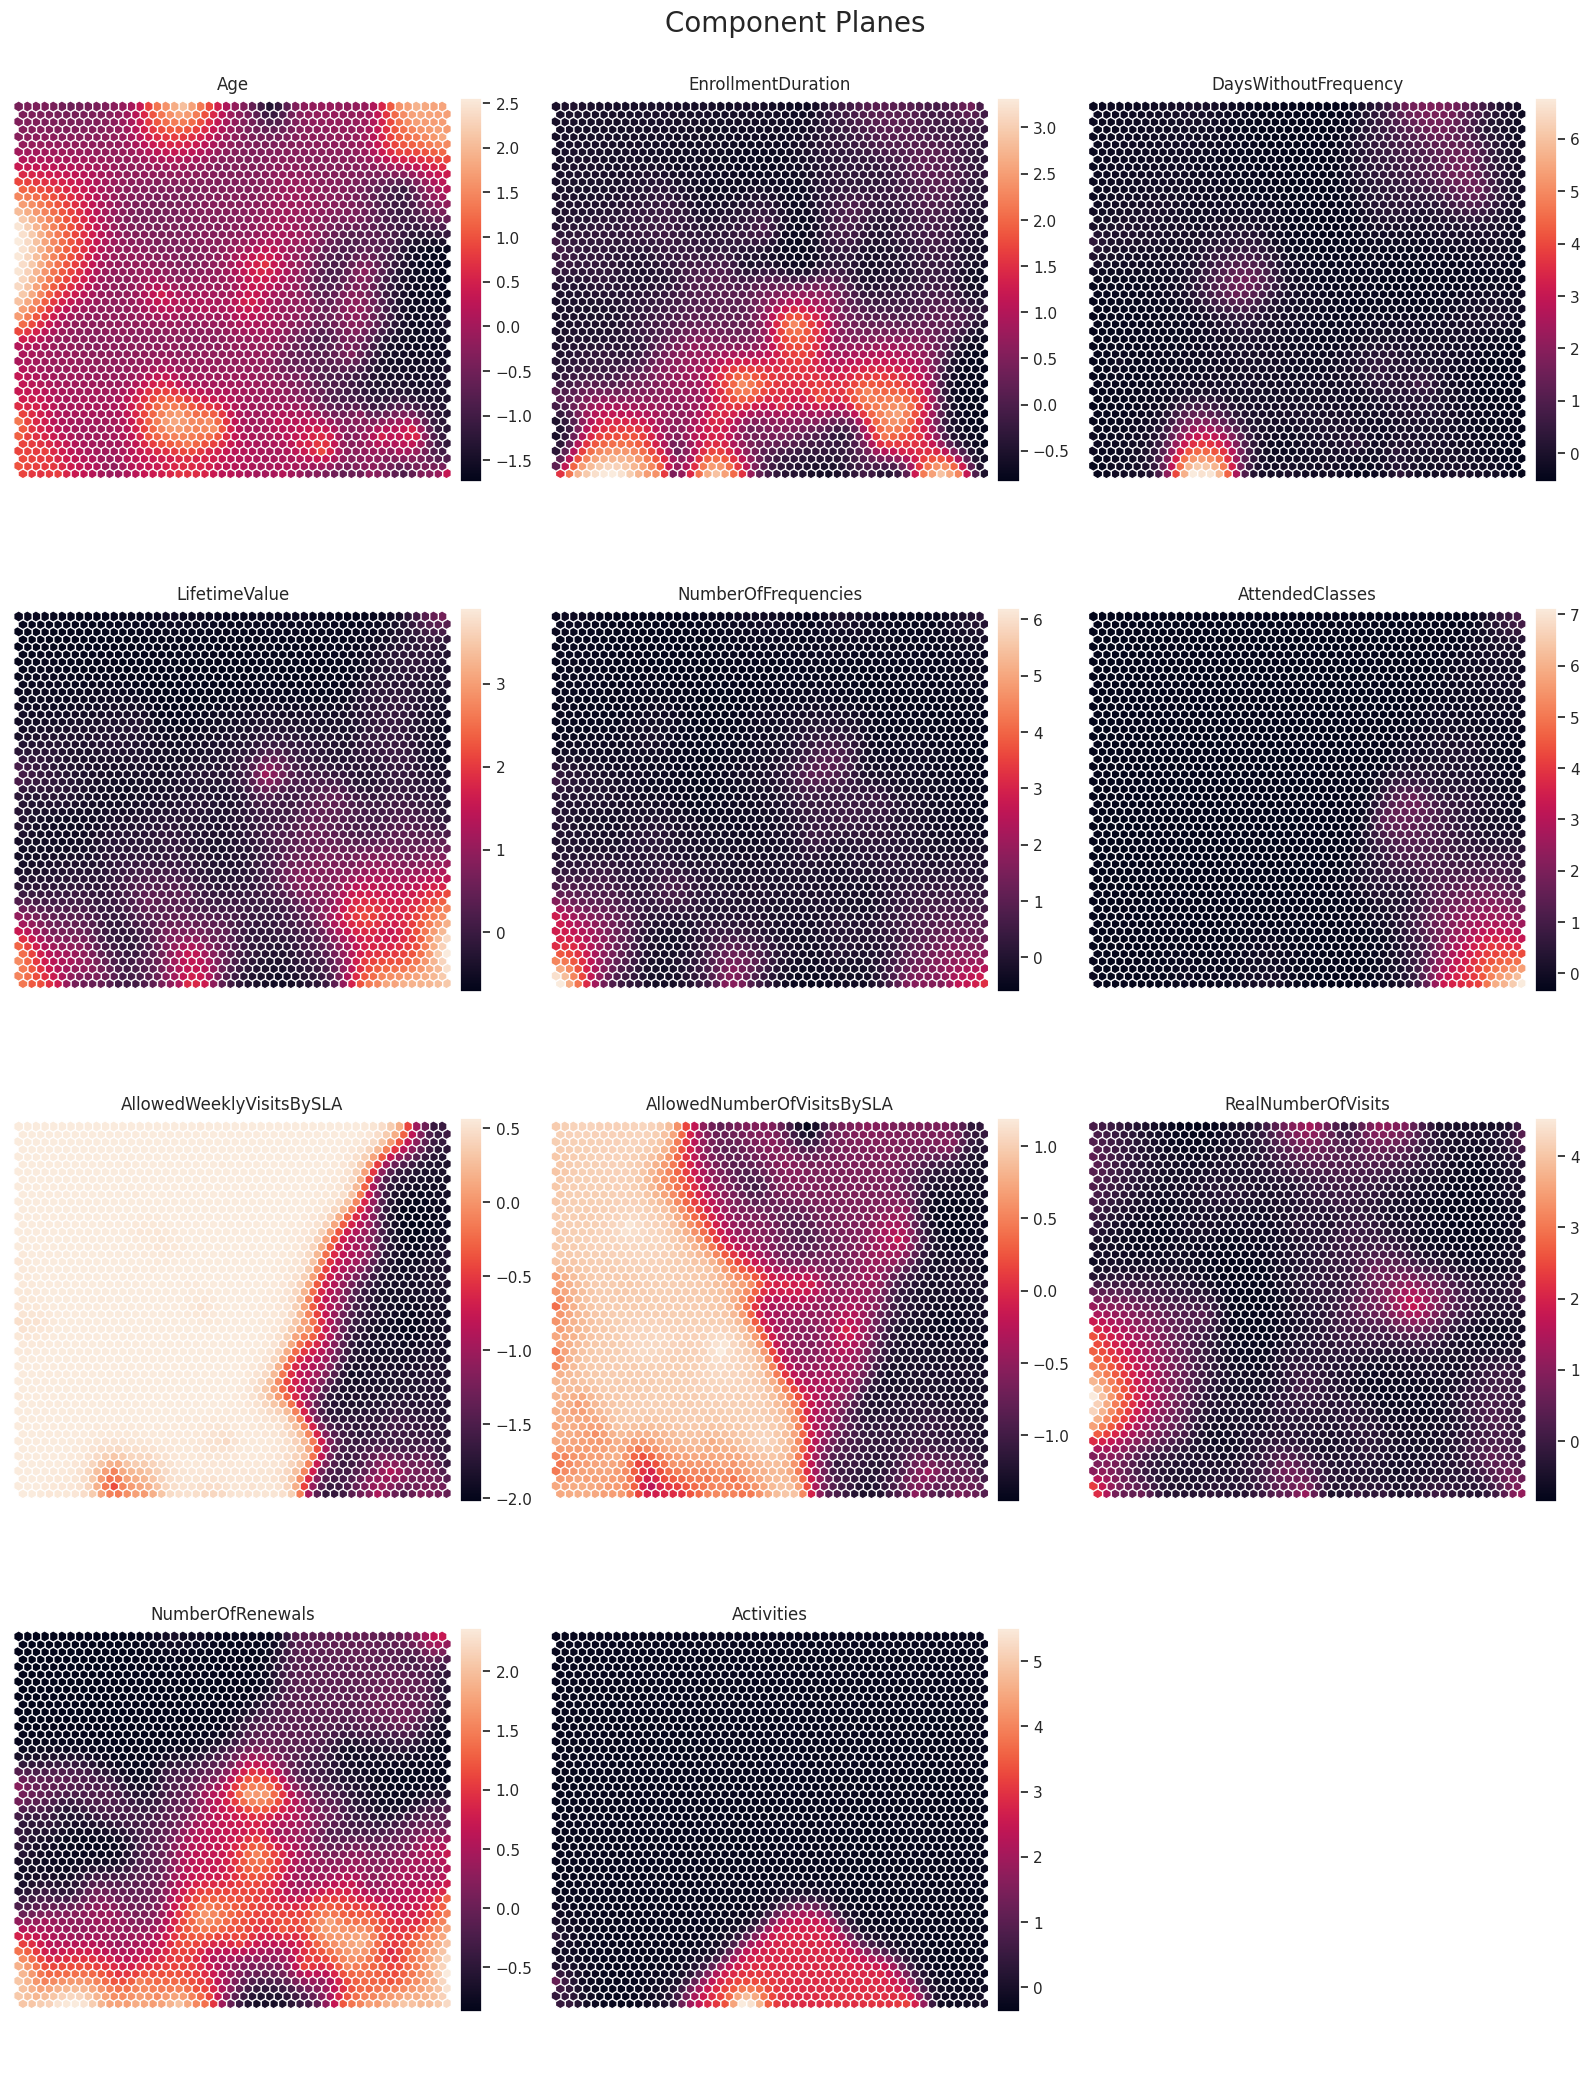

In [92]:
sns.set()
view2D = View2D(12,12,"", text_size=10)
view2D.show(sm, col_sz=3, what='codebook')
plt.subplots_adjust(top=0.90)
plt.suptitle("Component Planes", fontsize=20)
plt.tight_layout()
plt.show();

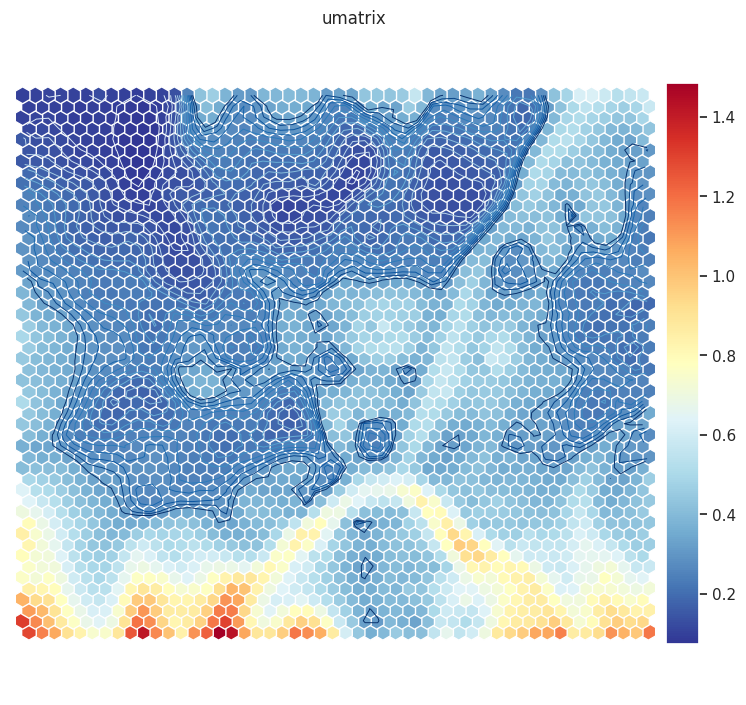

In [93]:
u = sompy.umatrix.UMatrixView(7, 7, 'umatrix', show_axis=True, text_size=8, show_text=True)

UMAT = u.show(
    sm,
    distance=2,
    row_normalized=False,
    show_data=False,
    contour=True # Visualize isomorphic curves
)

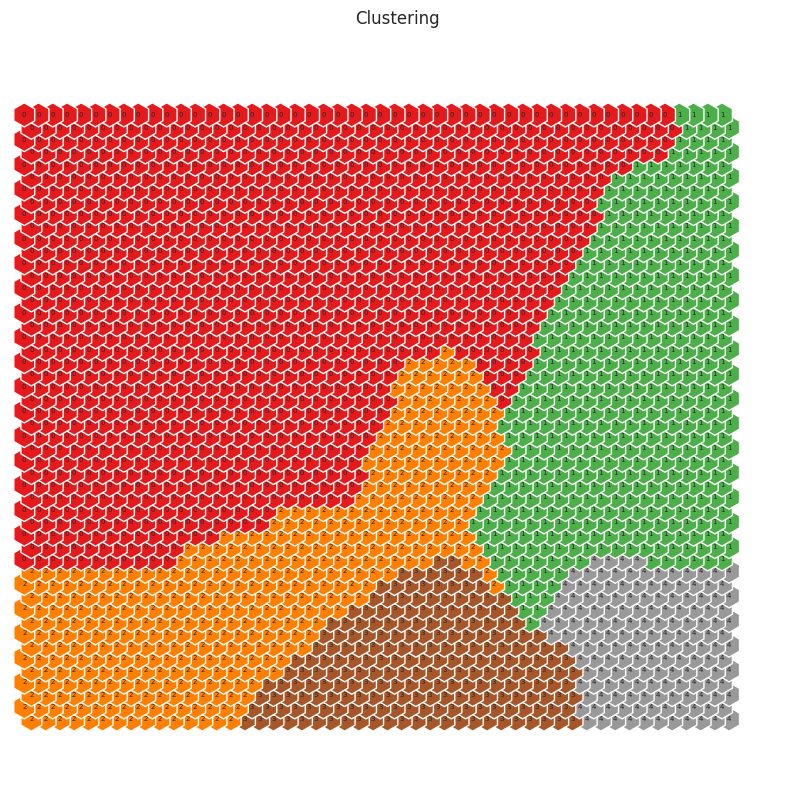

In [94]:
kmeans_som = KMeans(n_clusters=5, init='k-means++', n_init=100)
nodeclus_labels = kmeans_som.fit_predict(sm.codebook.matrix)
sm.cluster_labels = nodeclus_labels  # setting the cluster labels of sompy

hits = HitMapView(10, 10,"Clustering", text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=5, cmap="Set1")

plt.show();

## UMAP

- **Hierarchical Clustering**

In [95]:
df_umap = df_concat.copy()

In [96]:
reducer = UMAP(n_neighbors=15, min_dist=0.1, n_components=2)
embedding = reducer.fit_transform(df_umap[metric_features])

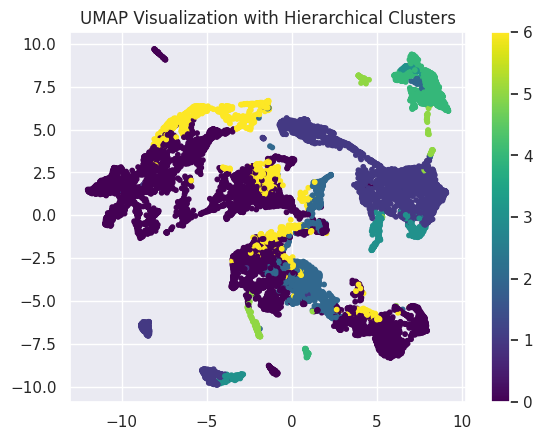

In [97]:
plt.scatter(embedding.loc[:, 0], embedding.loc[:, 1], c=df_umap['labels'], s=10, cmap='viridis')
plt.title('UMAP Visualization with Hierarchical Clusters')
plt.colorbar()
plt.show()

- **K-Means Clustering**

In [98]:
df_umap = df_kmeans.copy()

In [99]:
reducer_kmeans = UMAP(n_neighbors=7, min_dist=0.1, n_components=2)
embedding_kmeans = reducer.fit_transform(df_umap[metric_features])

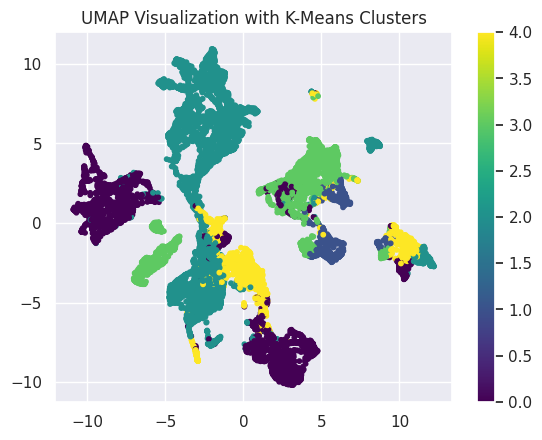

In [100]:
plt.scatter(embedding_kmeans.loc[:, 0], embedding_kmeans.loc[:, 1], c=df_umap['cluster_labels'], s=10, cmap='viridis')
plt.title('UMAP Visualization with K-Means Clusters')
plt.colorbar()
plt.show()

## 3.3 Cluster Interpretation

* We'll unscale the features in order to get a more accurate depiction of the clusters

- **Hierarchical Clustering**

In [101]:
df_concat[metric_features] = scaler.inverse_transform(df_concat[metric_features])

In [102]:
cluster_means = df_concat.groupby('labels').mean()[metric_features].T
cluster_means.style.format(precision=2).background_gradient(axis=1)

- **K-Means Clustering**

In [103]:
df_kmeans[metric_features] = scaler.inverse_transform(df_kmeans[metric_features])

In [104]:
cluster_kmeans = df_kmeans.groupby('cluster_labels').mean()[metric_features].T
cluster_kmeans.style.format(precision=2).background_gradient(axis=1)

* Radial plots to help characterize the clusters

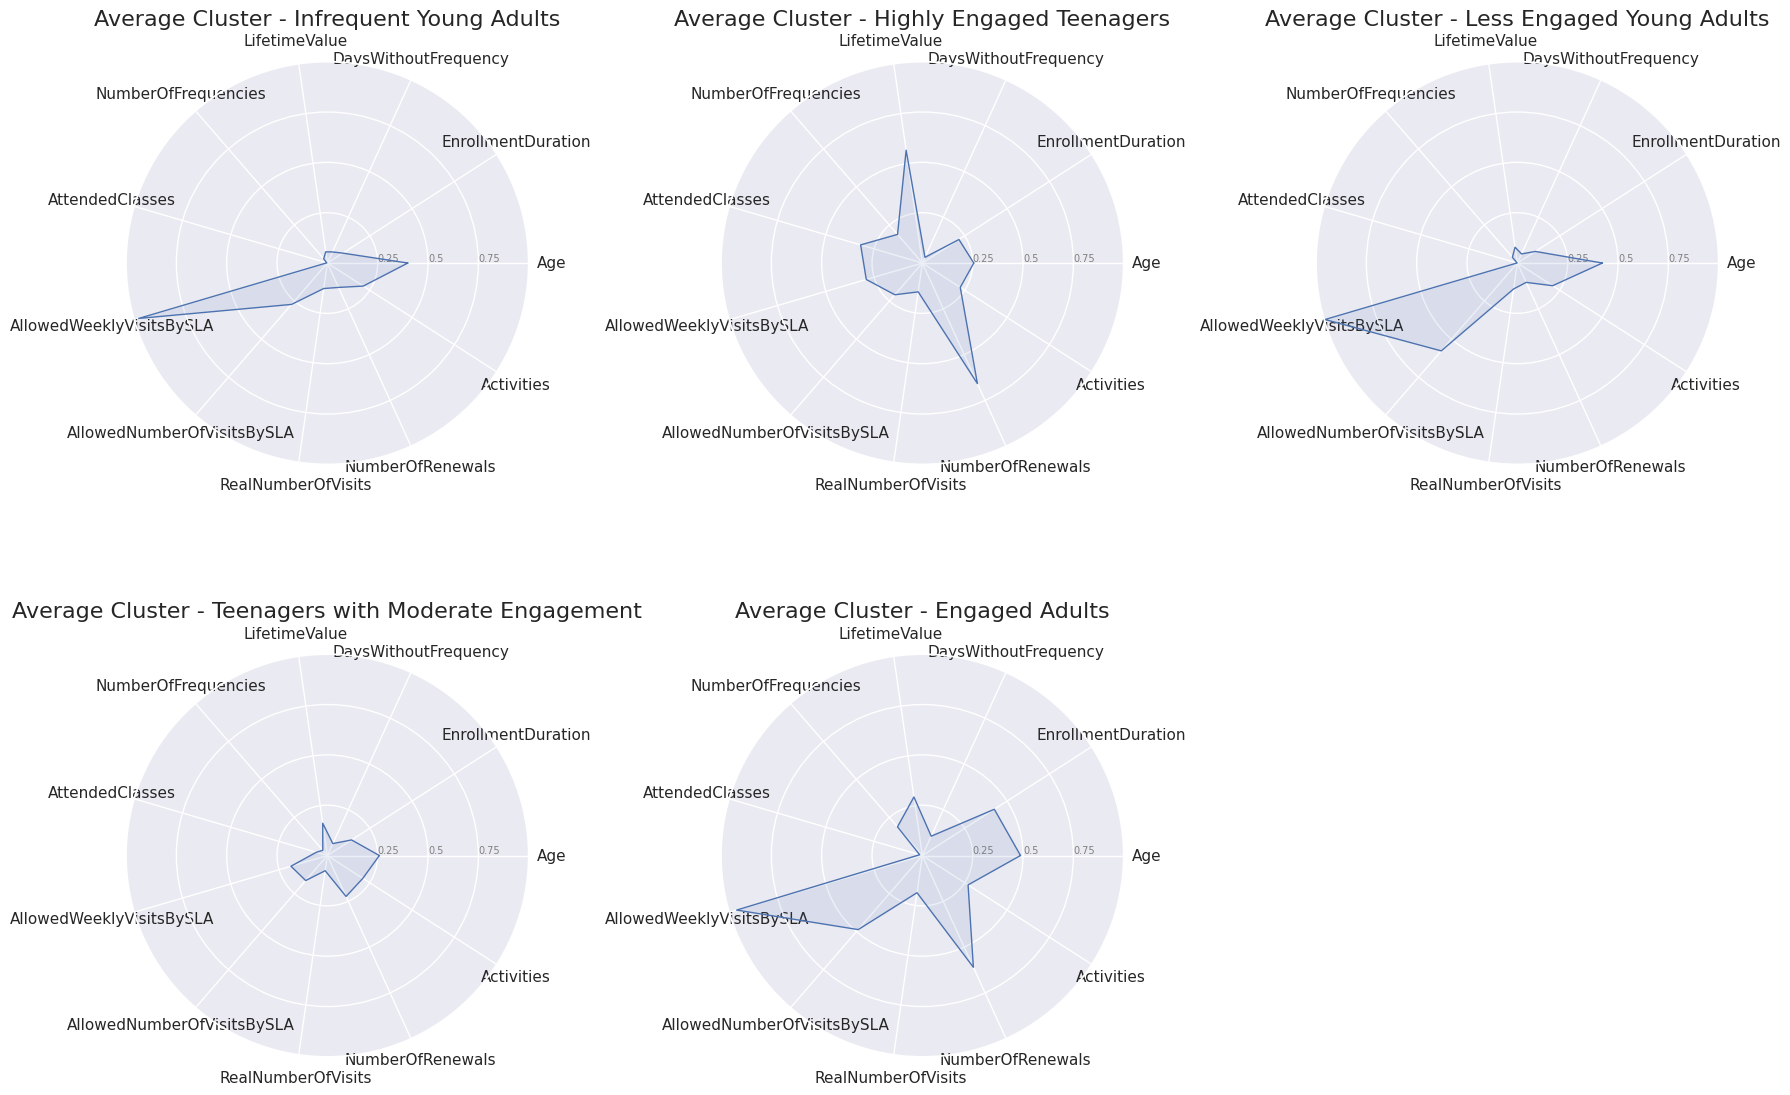

In [106]:
df_radar = df_kmeans.copy()
df_radar[metric_features] = MinMaxScaler().fit_transform(df_radar[metric_features])

cluster_names = {0: "Infrequent Young Adults", 1: "Highly Engaged Teenagers", 2: "Less Engaged Young Adults",
                 3: "Teenagers with Moderate Engagement", 4:"Engaged Adults"}

# Create a 2x3 subplot layout
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12), subplot_kw=dict(polar=True))
axes = axes.flatten()  # Flatten the 2D array of axes to easily iterate over them

for i in range(5):
    # Calculating the mean for each numeric feature
    mean_values = df_radar[df_radar['cluster_labels'] == i][metric_features].mean().tolist()
    mean_values += mean_values[:1]  # Ensures the radar chart is closed

    # Number of variables we're plotting
    num_vars = len(metric_features)

    # Compute angle for each axis
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]

    # Radar chart plot on the ith subplot
    ax = axes[i]

    # Draw one axe per variable and add labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metric_features)

    # Draw ylabels
    ax.set_rlabel_position(0)
    ax.set_yticks([0.25, 0.5, 0.75])
    ax.set_yticklabels(["0.25","0.5","0.75"], color="grey", size=7)
    ax.set_ylim(0, 1)

    # Plot data
    ax.plot(angles, mean_values, linewidth=1, linestyle='solid')

    # Fill area
    ax.fill(angles, mean_values, 'b', alpha=0.1)

    # Title
    ax.set_title(f'Average Cluster - {cluster_names[i]}', size=16)

# Hide the 6th subplot as we only have 5 clusters
axes[5].set_visible(False)

plt.tight_layout()
plt.show();